In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Assignment 3 - Clustering

For this assignment you'll need to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

The modelling parts of this assignment are not very complex, the application of the clustering algorithms is very similar to the examples from class. This will require a little more manipulation of data, and building a little bit of structure around the models, that's where some of the challenge lies. 

## Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li> Do not use the targets from the dataset at all. 
    <li> Use as many clusters as you think is appropriate.
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li><b>So, to this point. You take the images, ditch their labels, and do clustering to group them. You don't know which cluster is which digit. You have to then label them, or look at each one and say, "looks like 7s", then assign that group a label of 7. </b>
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. Each digit should be a new generation of data.</b>
</ul>

## Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Within your file, create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits. The function should be callable like this, if I wanted to print the number 218201

~~~
writeNumber(218201)
~~~

This would produce something that looks, somewhat, like this:

![Writing Example](example.png "Writing Example" )

The exact appearance of the generated writing can vary, it likely won't be as well defined as this picture. As long as I can read it as a number, it is fine. 

Hint: the number of clusters may vary. 

## Grading
<ul>
<li> 70% - Code works. This is mostly a yes/no thing, if it doesn't work I'll try to see if it was a small or large issue in the code, but it largely works or it doesn't. 
<li> 20% - Numbers appearance. Is the writing OK? I'm not going to be overly picky, if they are reasonably legible, that is fine. 
<li> 10% - Code legibility. Is a quick read over of the code clear? Sections, comments, etc... 
</ul>

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [2]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
#mnist = mnist[0:15000]
X = mnist["data"]
print(X.shape)

(70000, 784)


The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. It contains 70000 images and normalized to fit into a 28X28 pixel bounding box-Google

Research Help from:
<li>https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
<li>https://github.com/sharmaroshan/MNIST-Using-K-means/blob/master/KMeans%20Clustering%20for%20Imagery%20Analysis%20(Jupyter%20Notebook).ipynb
<li>https://notebook.community/xdnian/pyml/assignments/ex06_ch1113_xdnian
<li>https://www.kaggle.com/code/dhruv8680/semi-supervised-learning-mnist-dataset-kmeans
<li>https://scarf.readthedocs.io/en/latest/vignettes/mnist.html
<li> Data 3950 ML Class lecture notebook on Clustering

For the fun of it:
<li>plt.rcParams["figure.figsize"] = (20,8)
<li>dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

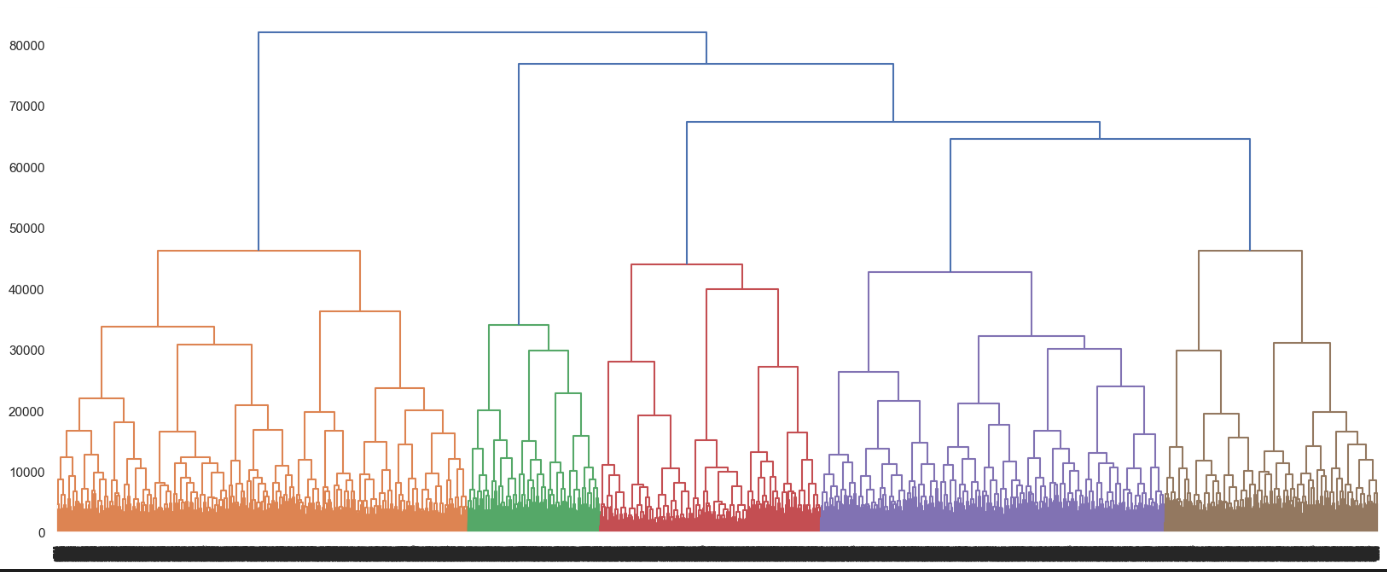

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('X_scaled shape: ',X_scaled.shape)

X_scaled shape:  (70000, 784)


In [4]:
pca = PCA() # n_components used for 95% coverage
X_pca = pca.fit_transform(X_scaled) # Analysis fitted on X_scaled data
print('X_pca shape: ', X_pca.shape)

X_pca shape:  (70000, 784)


## Cluster 

We need to break the data into clusters first... 

### From here on, we can test on either use X_scaled or X_pca
<li>But i have decided to use X_scaled

In [5]:
def ELBOW(data, min, max):
    wss = []
    for i in range(min, max):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        wss.append(kmeans.inertia_)

    plt.plot(range(min, max), wss)
    plt.xlabel("Number of clusters")
    plt.ylabel("Within-cluster sum of squares")
    plt.title("Elbow method")
    return plt.show()

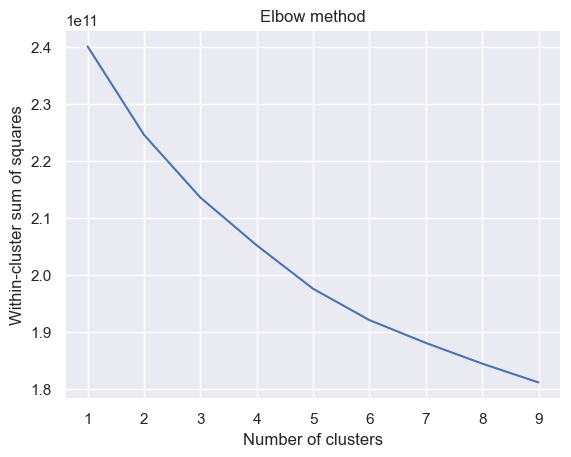

In [39]:
#ELBOW(X, 1, 10)

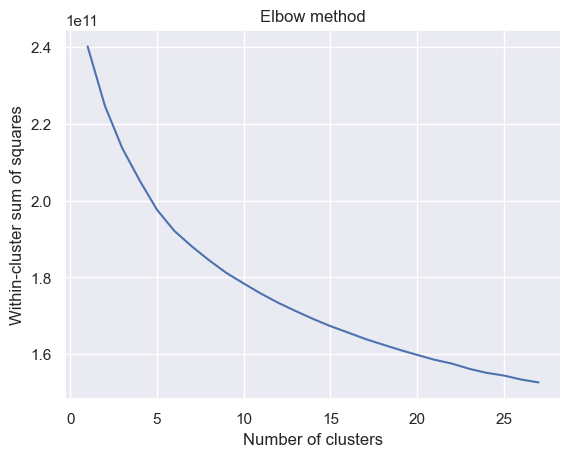

In [40]:
#ELBOW(X, 1, 28)

In [ ]:
#ELBOW(X, 1, 55) # this took way too long 

In [6]:
""" I have tried 10, 25 and 32 clusters, but finally decided to use 50.
     Using the elbow method, i was not able to exactly see where the elbow occurs.Hence decided to go with 50. 
     Intuition suggests that the more clusters you have for a problem like this, one would need many clusters to really actually try and ..
     seperate the digits from one another."""
kmeans = KMeans(n_clusters=50, random_state=42)
#randon_state set to 42 (can also use 101), so that we can get the same results everytime we run the code.
# This way we do not have to keep changing the mapping of the clusters in the section belows at label_mapping_50.
clusters = kmeans.fit_predict(X_scaled)

In [7]:
# Double check our labels with kmeans.labels_
kmeans.labels_

array([29, 22, 19, ..., 25,  9, 28])

In [8]:
# Double check our cluster_centres shape...
kmeans.cluster_centers_.shape

(50, 784)

In [9]:
# Get the count of each label in kmeans.labels_
counts = np.bincount(kmeans.labels_)

# Print the counts for each label
for i, count in enumerate(counts):
    print(f"Label {i}: {count}")

Label 0: 3902
Label 1: 529
Label 2: 3602
Label 3: 2370
Label 4: 1841
Label 5: 1386
Label 6: 947
Label 7: 1457
Label 8: 574
Label 9: 1381
Label 10: 273
Label 11: 905
Label 12: 136
Label 13: 413
Label 14: 2000
Label 15: 497
Label 16: 1343
Label 17: 1144
Label 18: 2552
Label 19: 201
Label 20: 2344
Label 21: 693
Label 22: 1991
Label 23: 1724
Label 24: 140
Label 25: 2718
Label 26: 790
Label 27: 2
Label 28: 1049
Label 29: 2023
Label 30: 3587
Label 31: 4255
Label 32: 1618
Label 33: 578
Label 34: 3355
Label 35: 3
Label 36: 276
Label 37: 630
Label 38: 727
Label 39: 3682
Label 40: 353
Label 41: 1418
Label 42: 1886
Label 43: 1
Label 44: 1
Label 45: 2968
Label 46: 111
Label 47: 127
Label 48: 37
Label 49: 3460


I was having a lot of brain storming issues on how to proceed from here. All my external reading on Medium.com and MachineLearningMastery.com and your class notes, you are all using/creating a new dataframe. Since we are not able to use the existing Minst['label']. But, we have to create our own labels from visually inspecting the output. So, I decided to move forward by creating a dataframe and adding 'Clusters' as a column. This then made it a lot easier when using the GaussianMixture model- Using test_df instead of X_scaled to be consistant with researched examples.

In [10]:
test_df=pd.DataFrame(X_scaled) # decided to create dataframe on X_scaled values instead of the original X values.
test_df['Clusters']=clusters
test_df.head()

0    1    2    3    4    5    6    7    8    9  ...       775      776  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387 -0.01675   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387 -0.01675   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387 -0.01675   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387 -0.01675   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387 -0.01675   

        777       778       779  780  781  782  783  Clusters  
0 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0        29  
1 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0        22  
2 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0        19  
3 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0        20  
4 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0        39  

[5 rows x 785 columns]

In [11]:
# Lets see the value_counts by cluster and see how many digits per cluster
test_df['Clusters'].value_counts()

31    4255
0     3902
39    3682
2     3602
30    3587
49    3460
34    3355
45    2968
25    2718
18    2552
3     2370
20    2344
29    2023
14    2000
22    1991
42    1886
4     1841
23    1724
32    1618
7     1457
41    1418
5     1386
9     1381
16    1343
17    1144
28    1049
6      947
11     905
26     790
38     727
21     693
37     630
33     578
8      574
1      529
15     497
13     413
40     353
36     276
10     273
19     201
24     140
12     136
47     127
46     111
48      37
35       3
27       2
43       1
44       1
Name: Clusters, dtype: int64

Viewing the contents of the 50 clusters so we can visually inspect and try to label them.

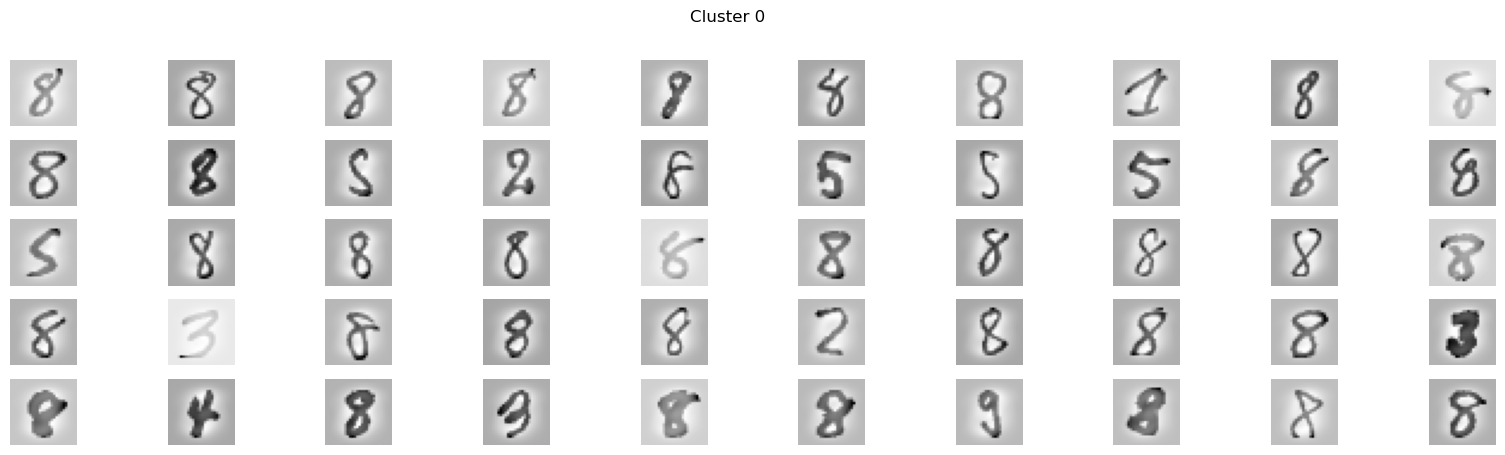

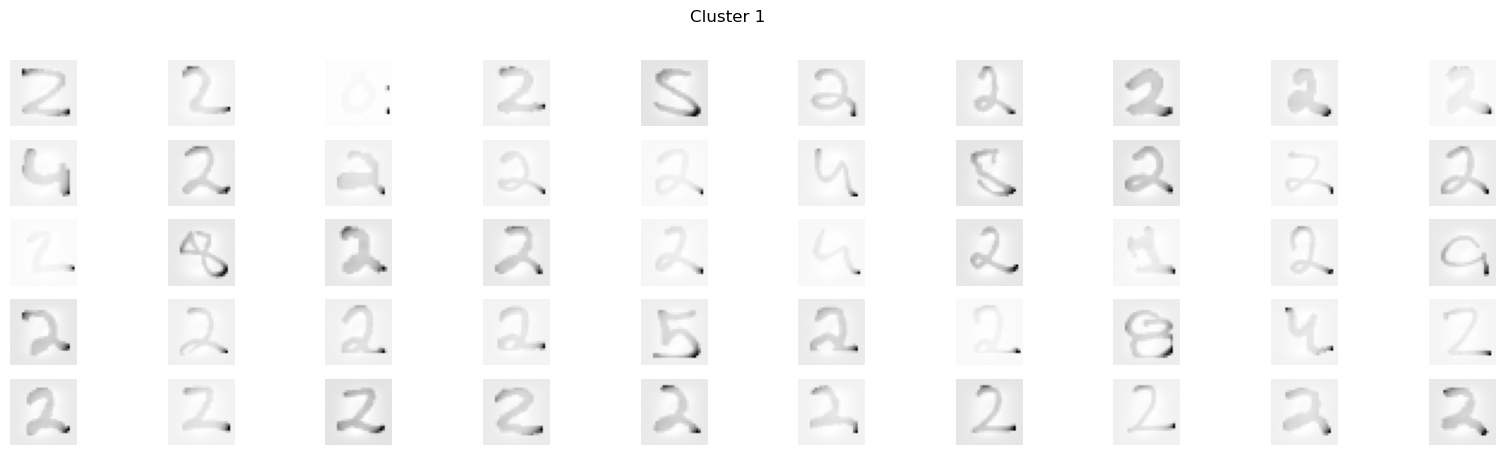

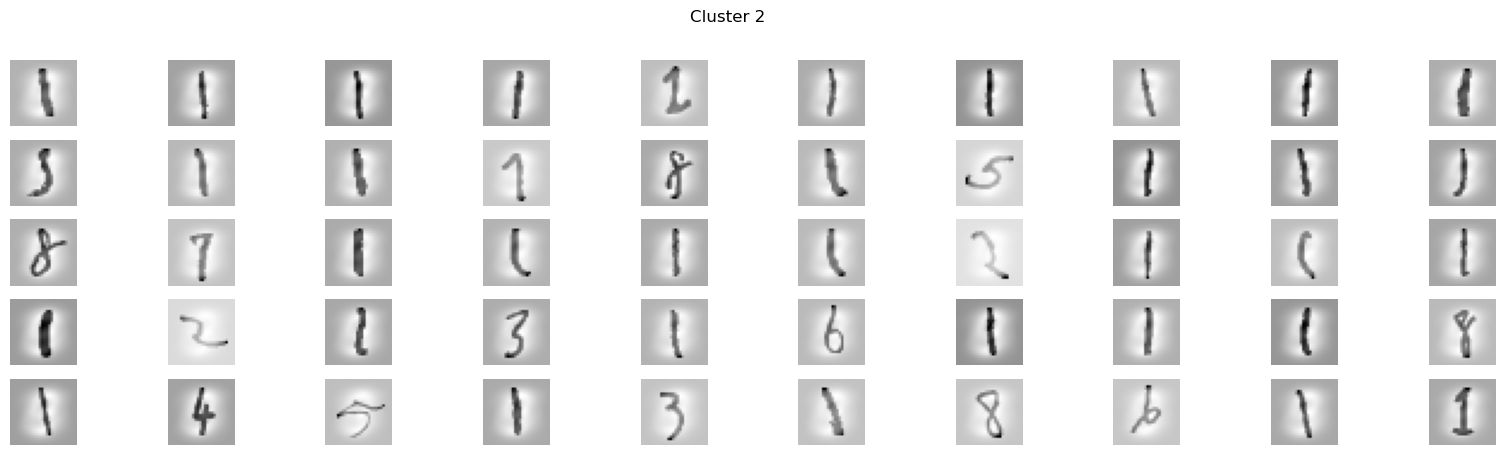

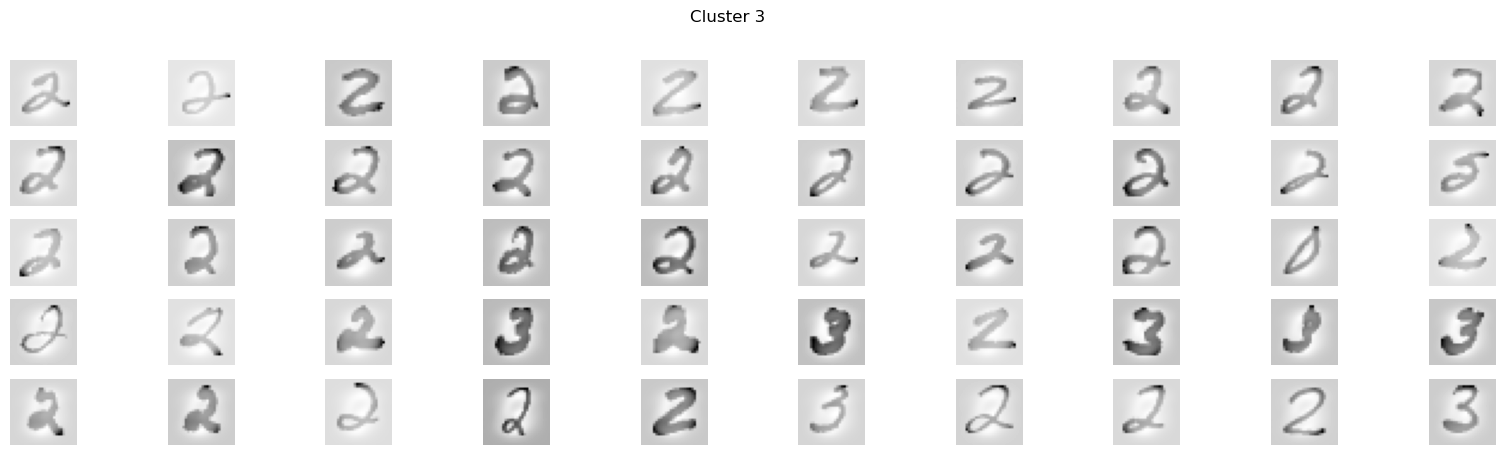

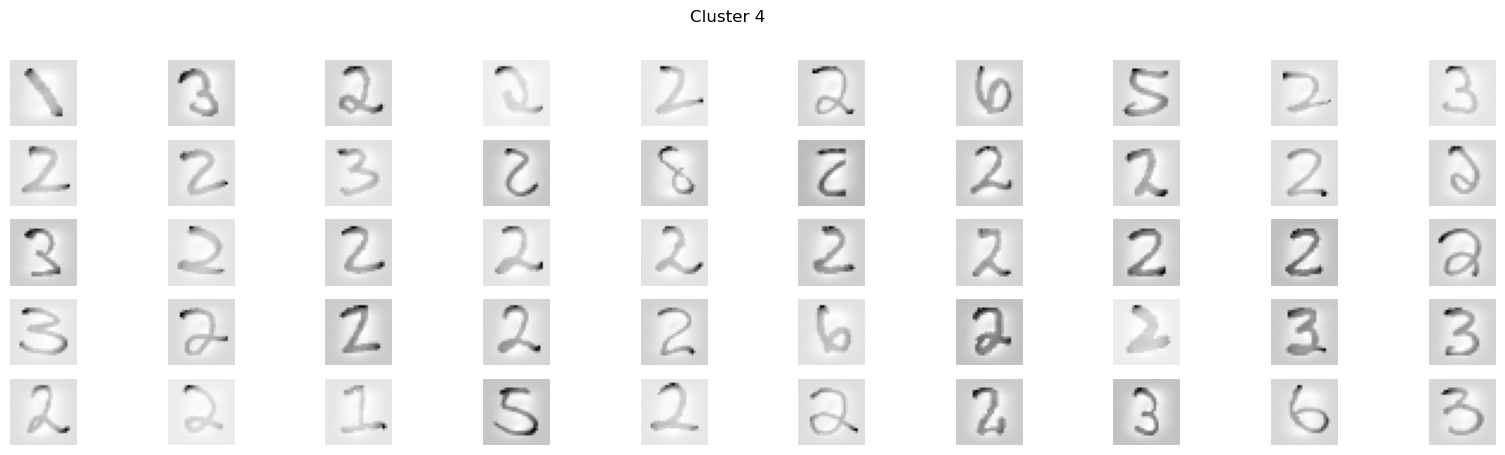

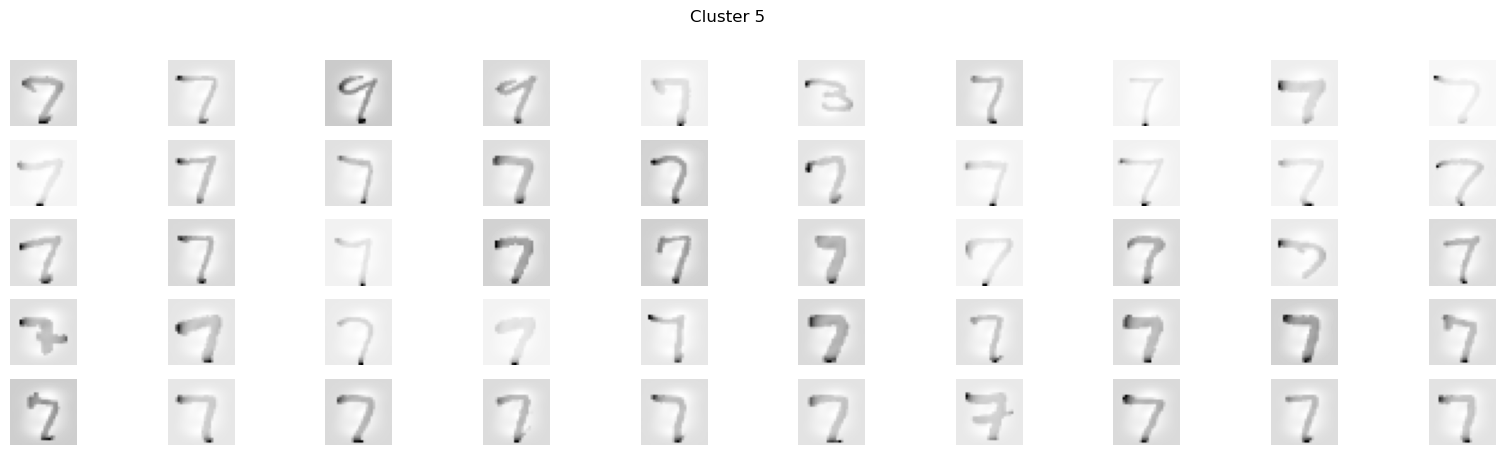

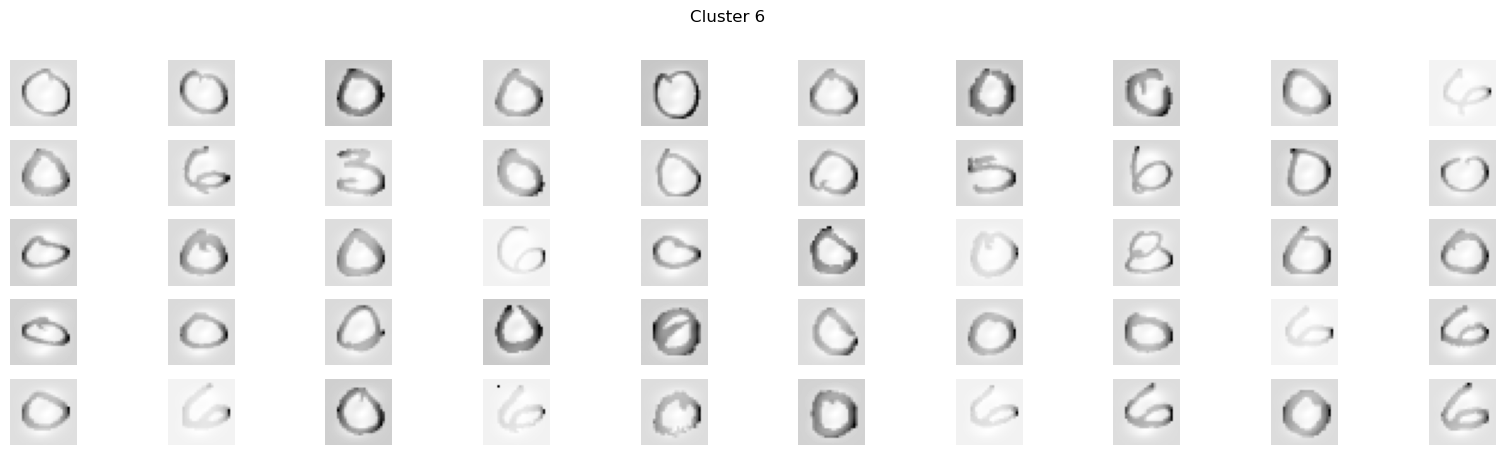

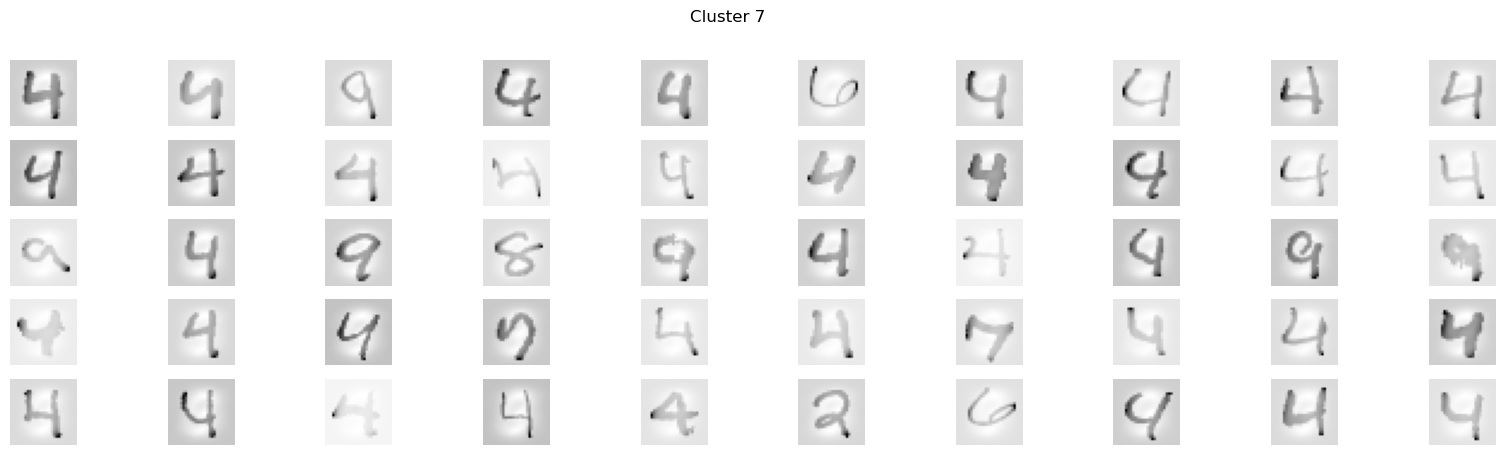

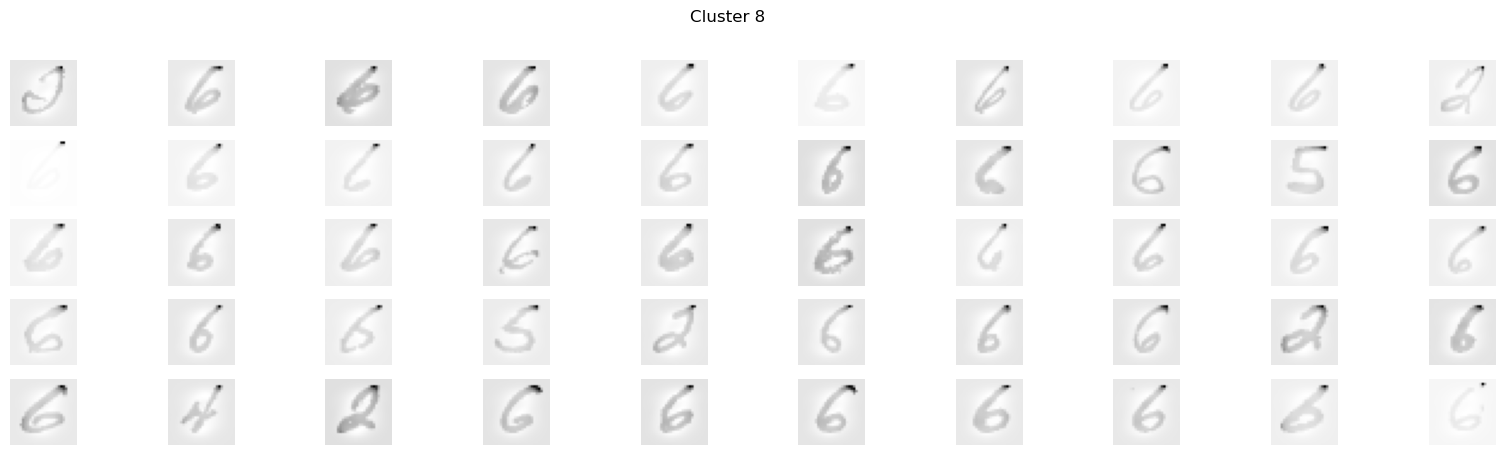

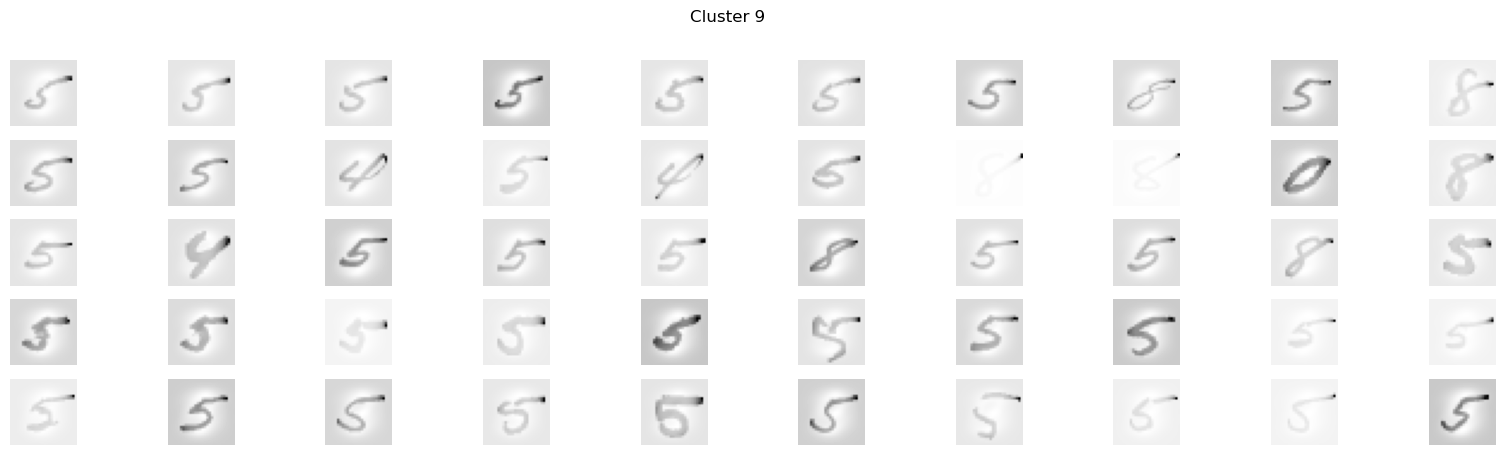

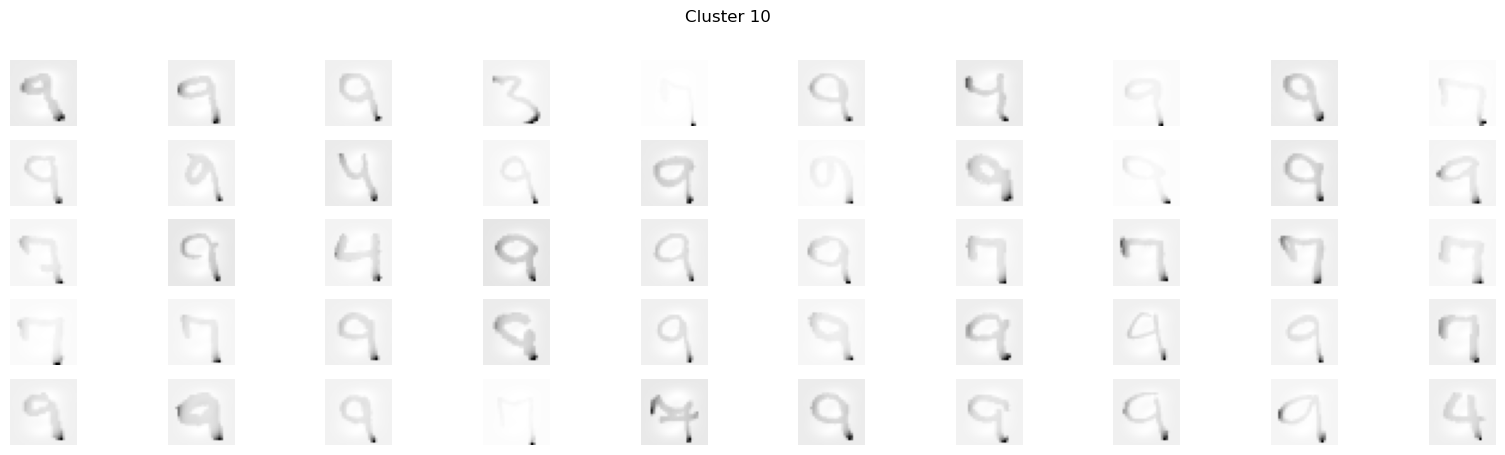

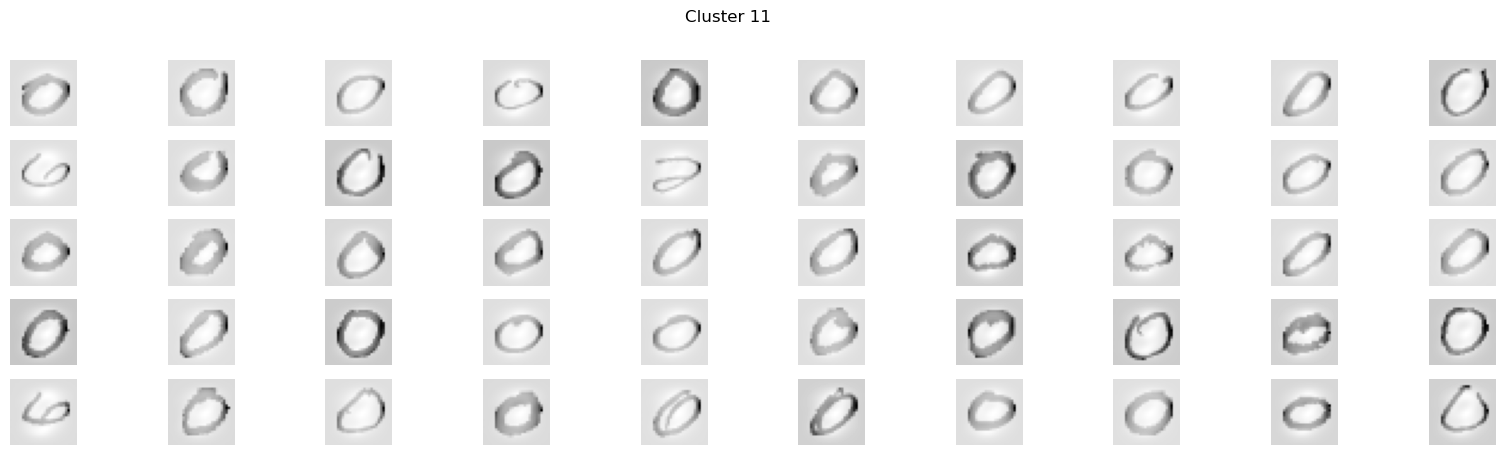

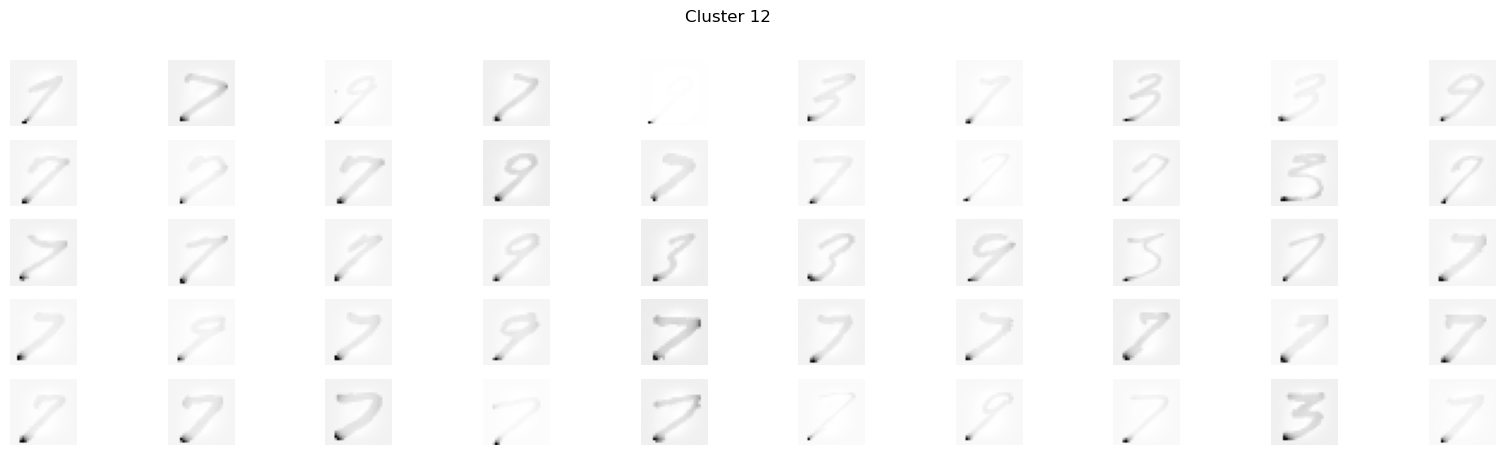

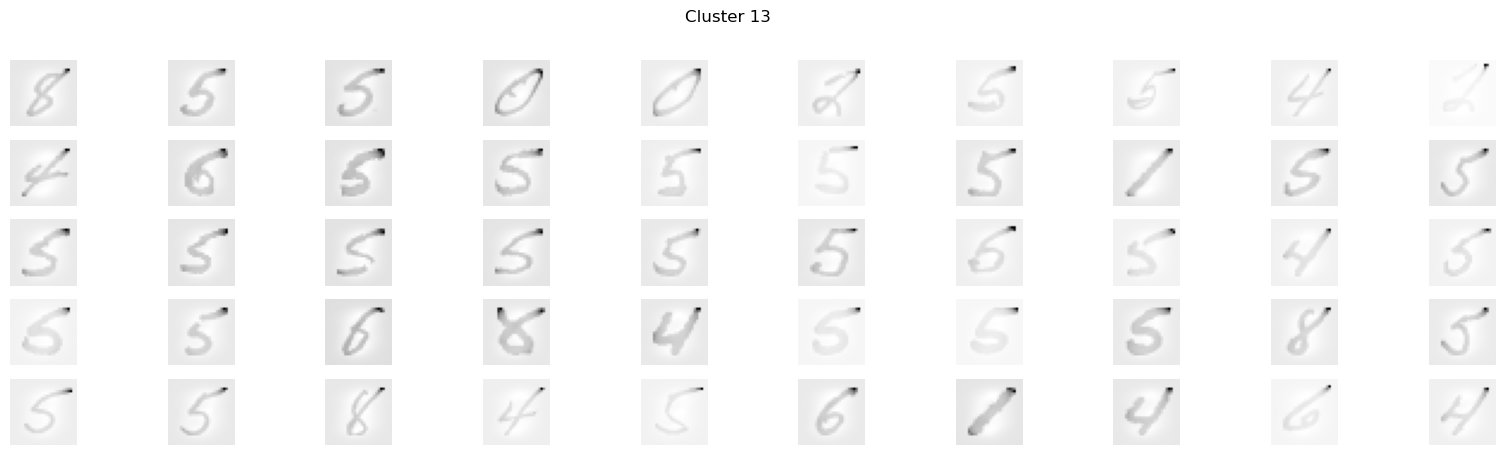

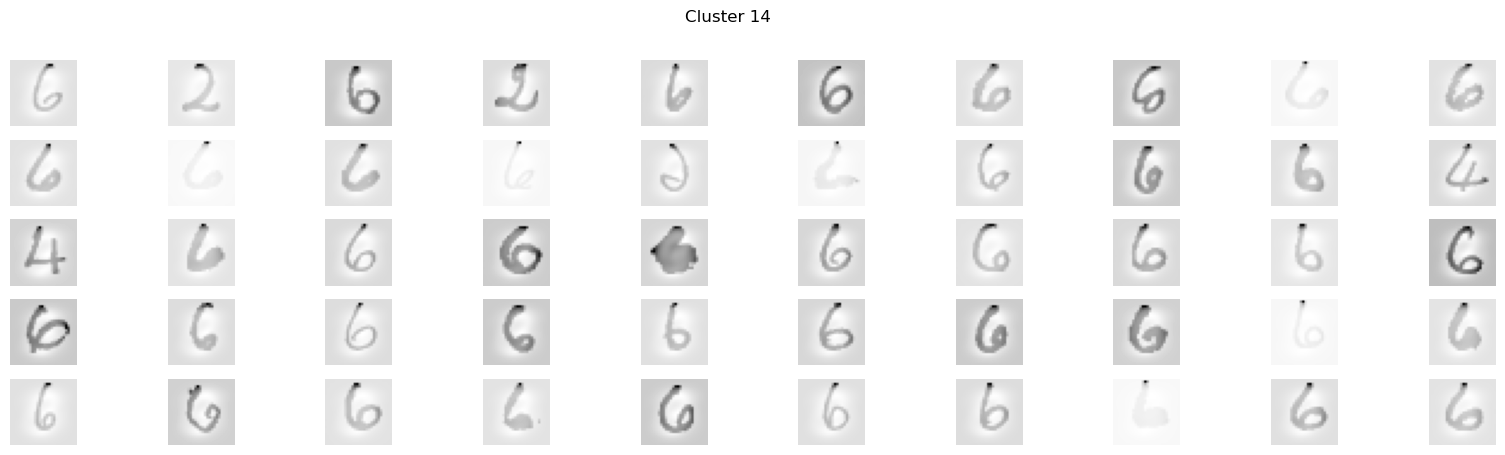

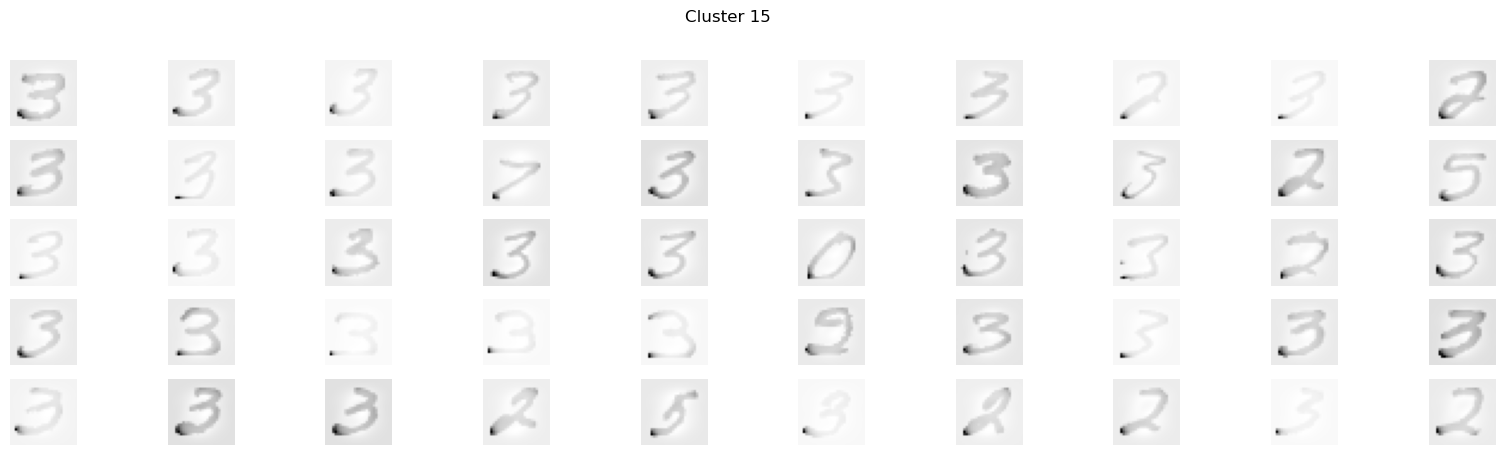

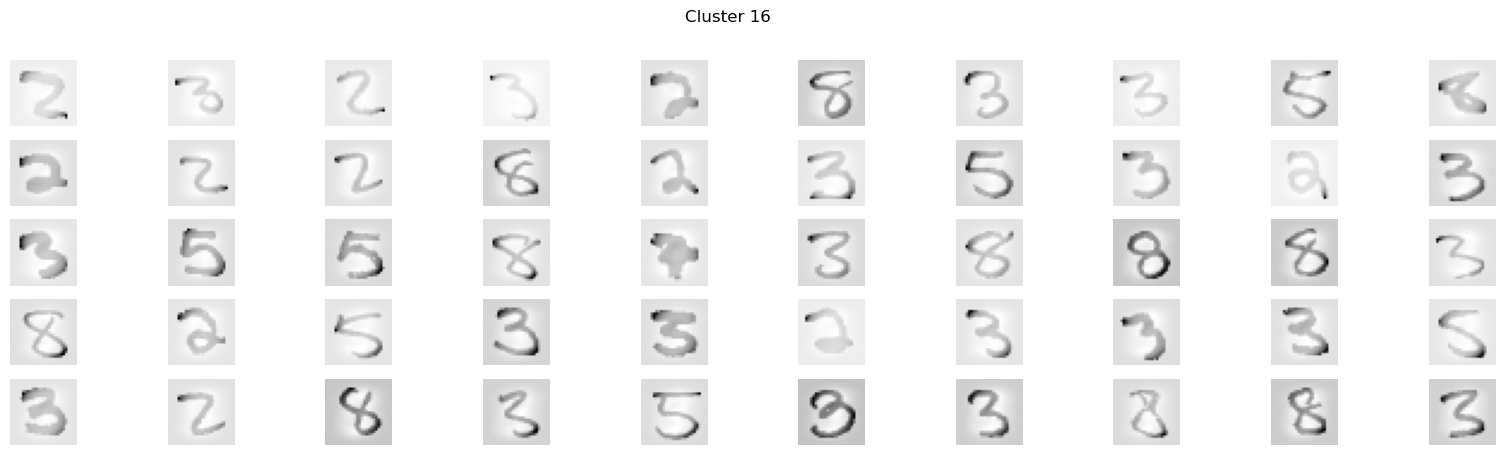

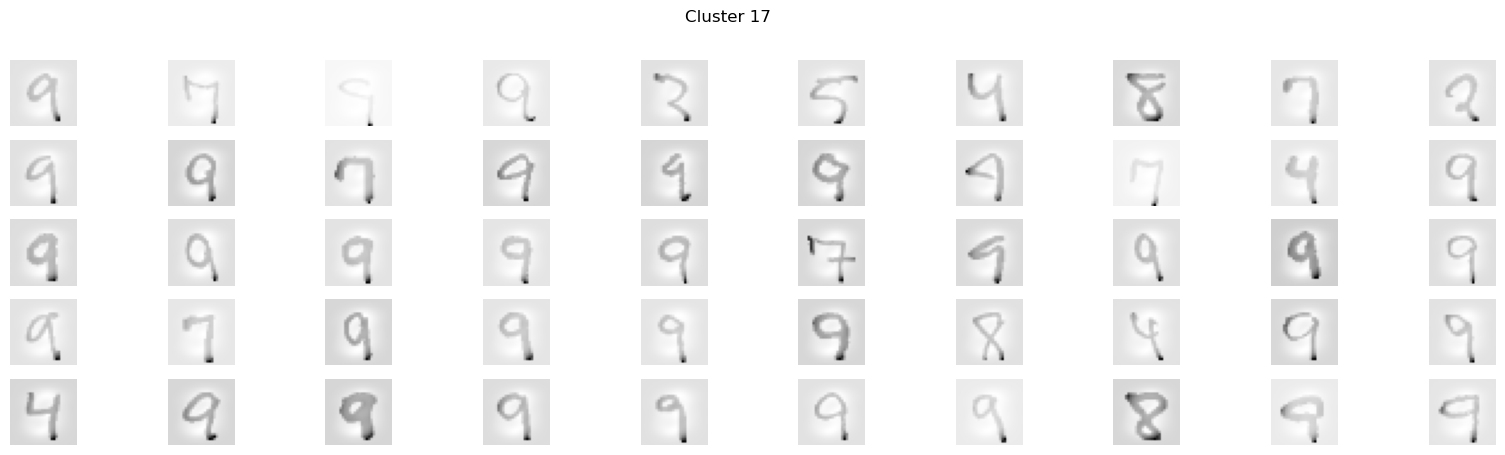

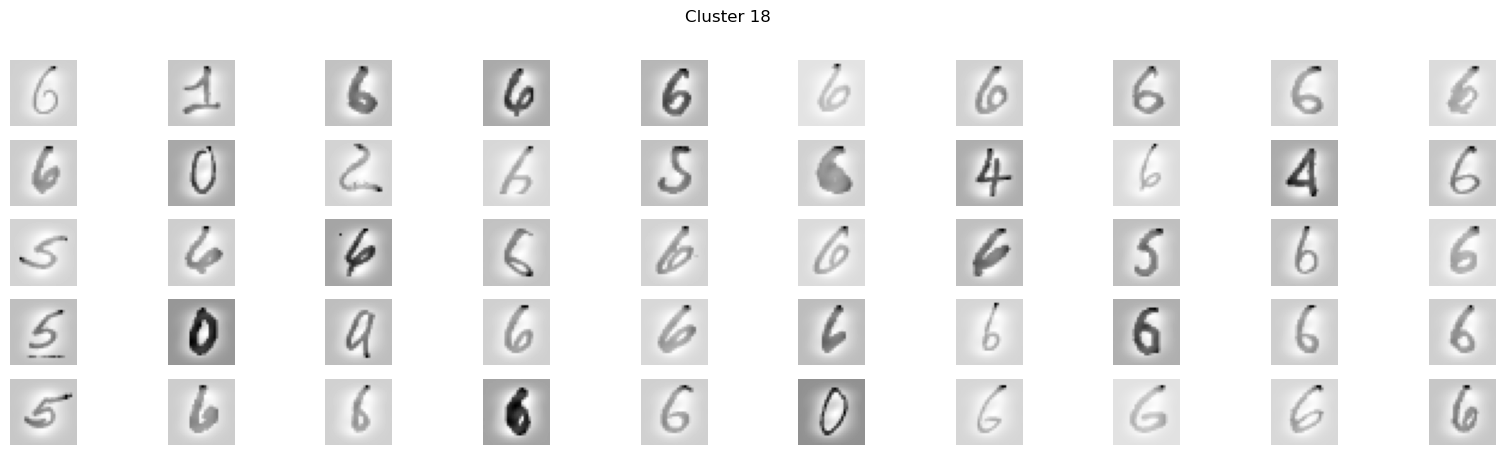

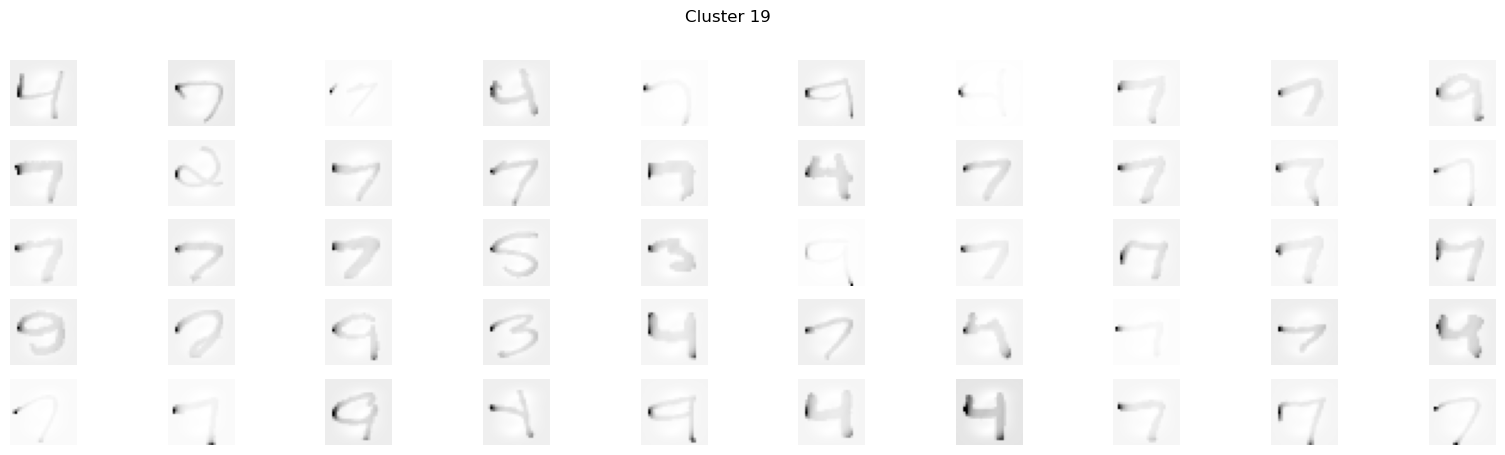

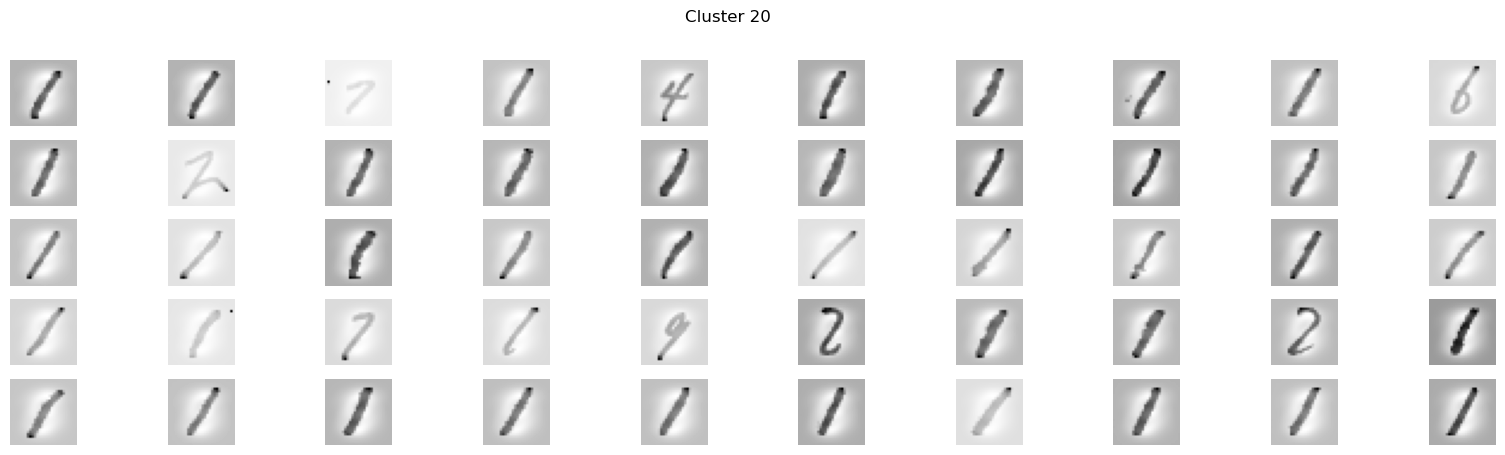

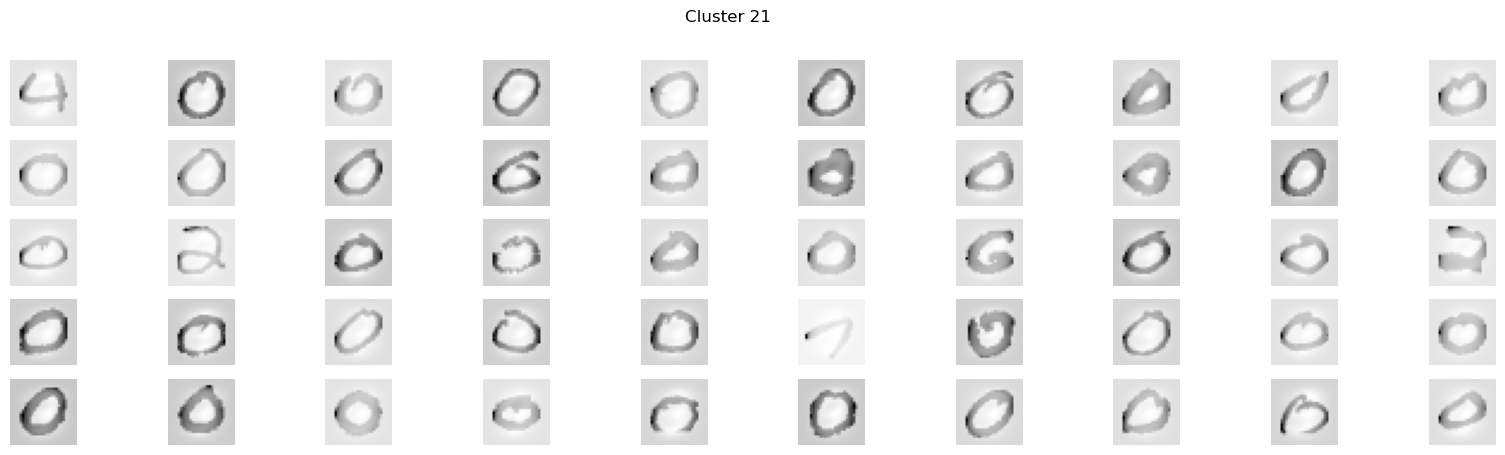

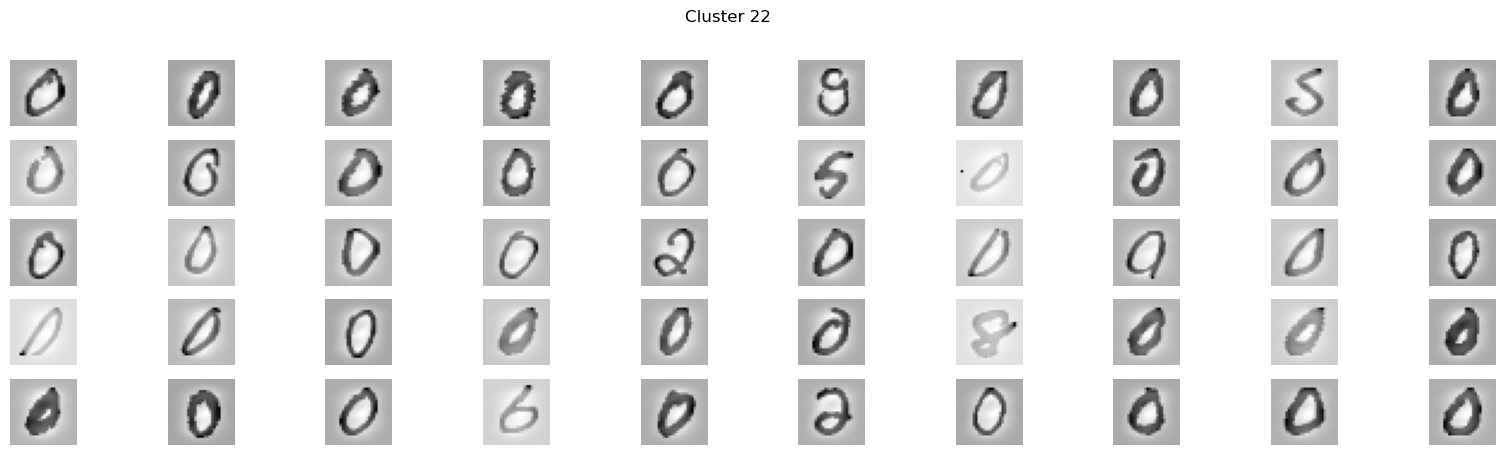

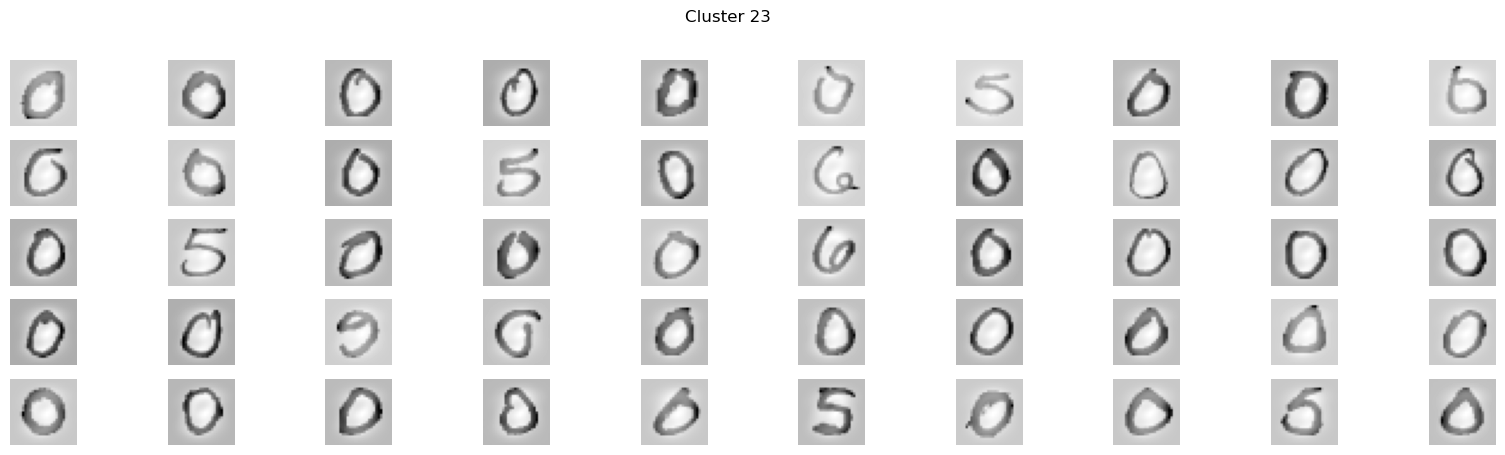

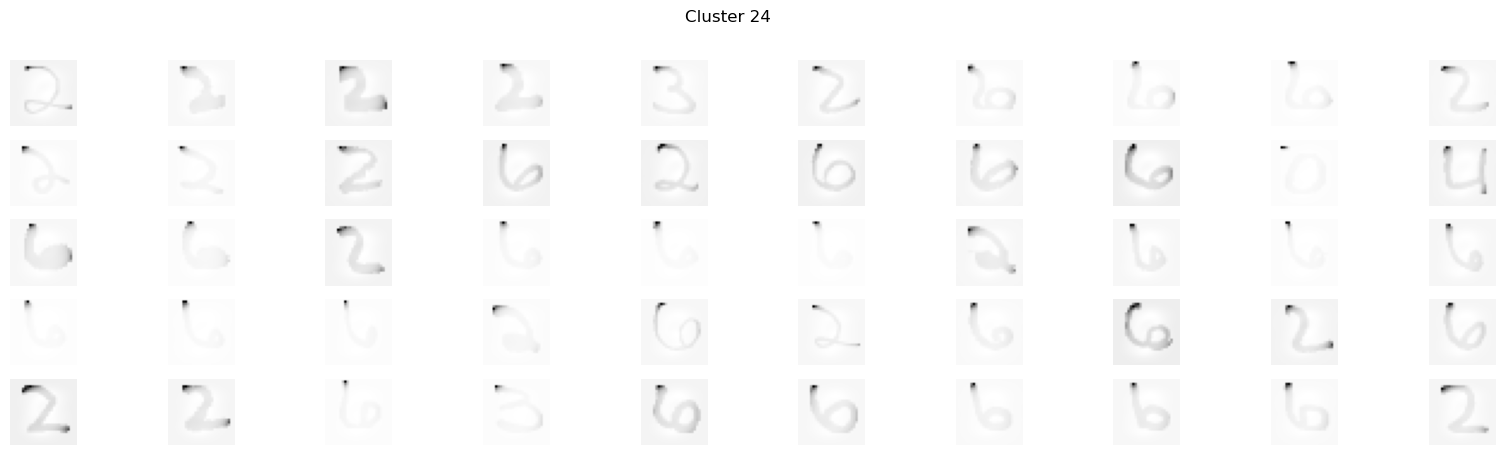

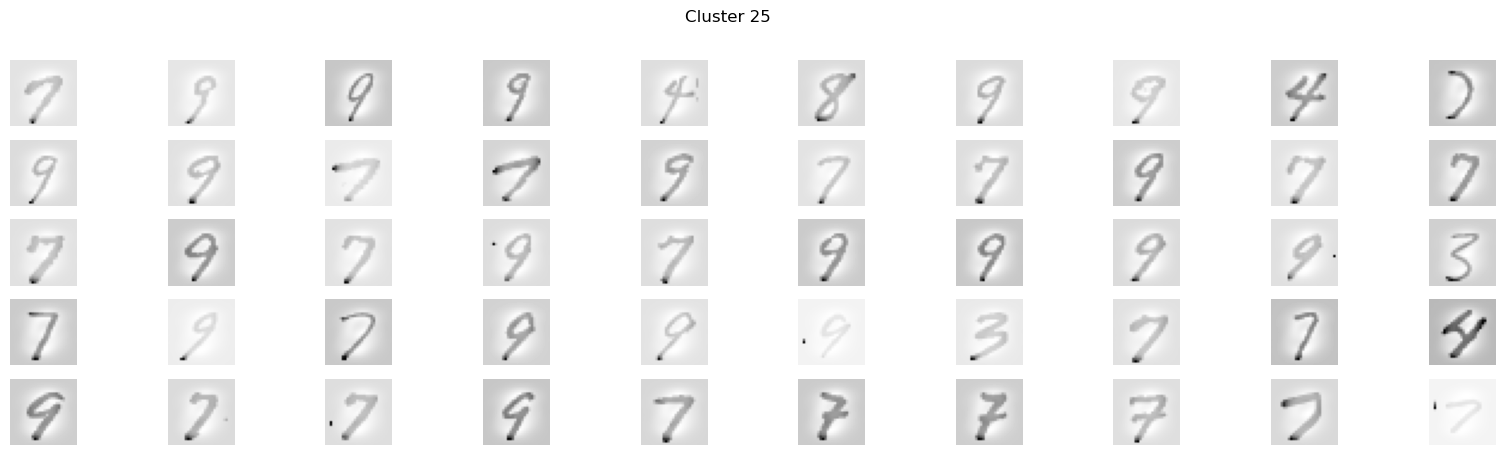

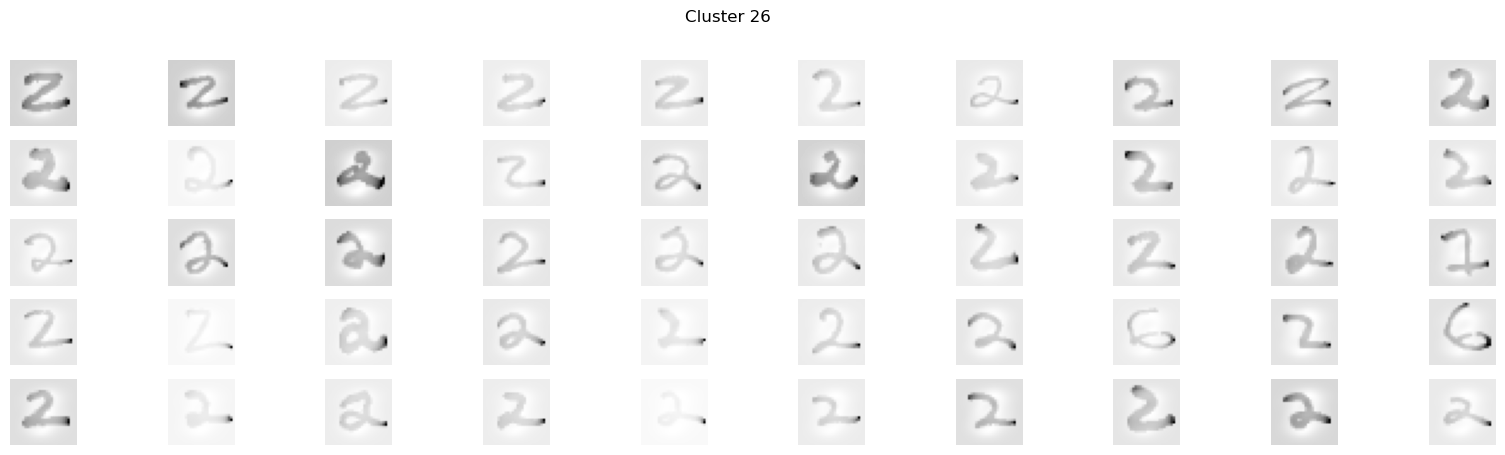

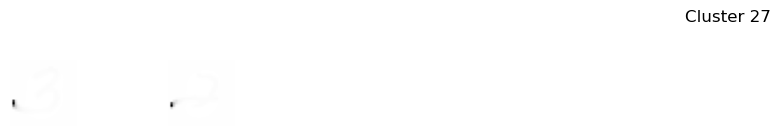

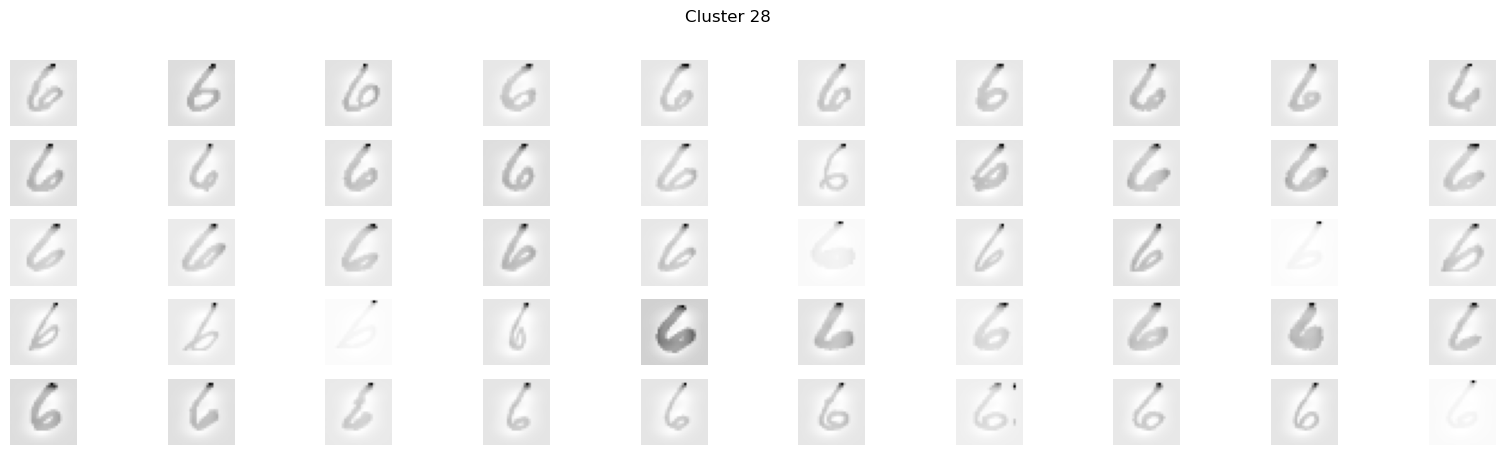

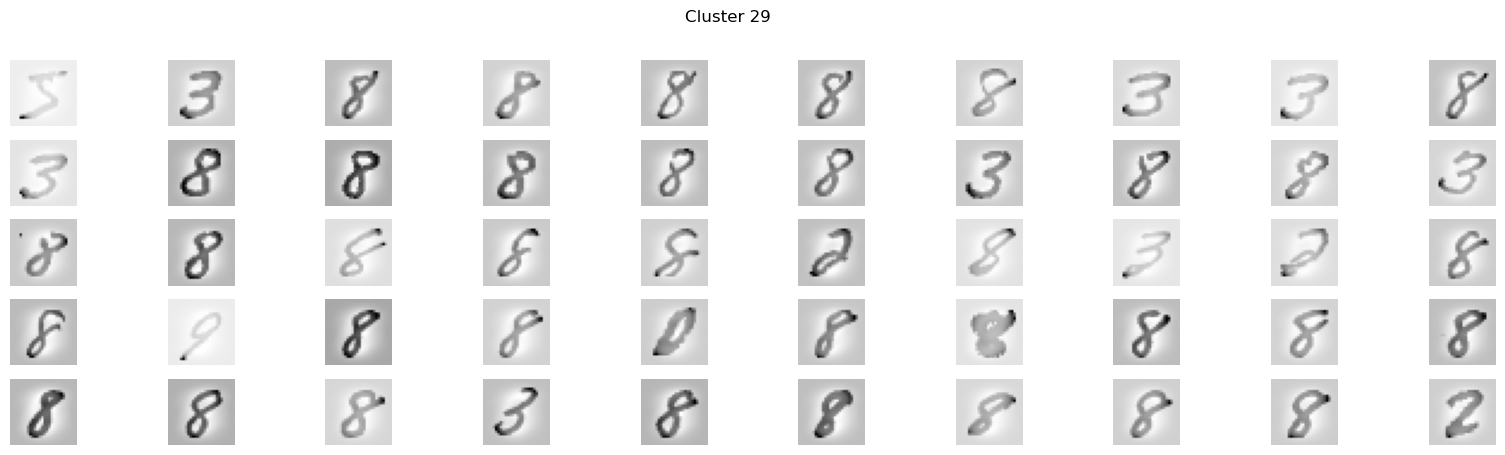

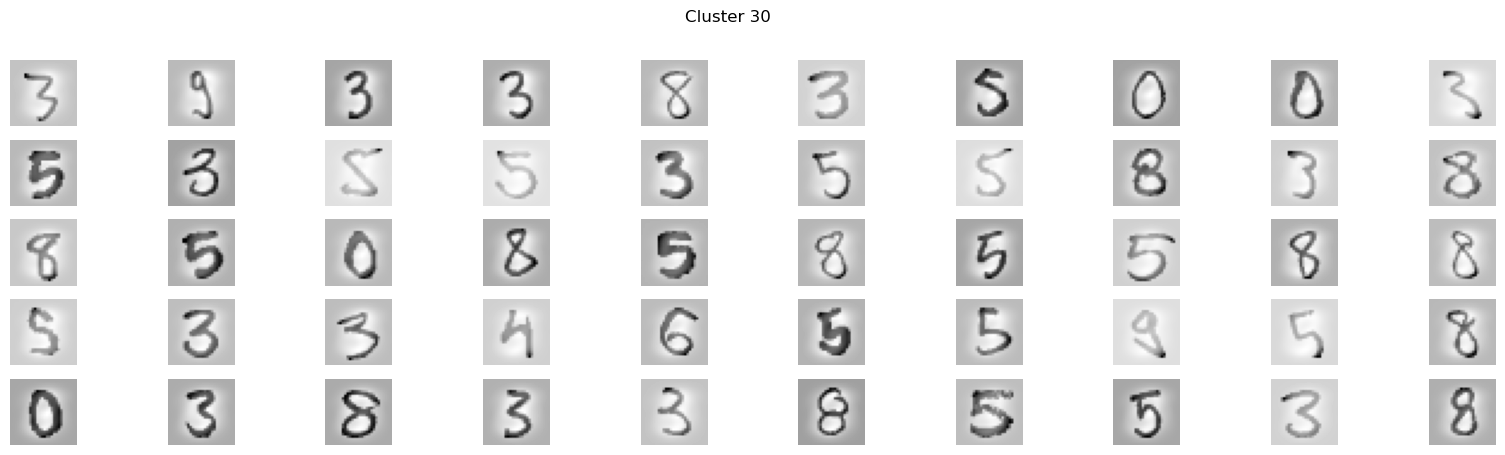

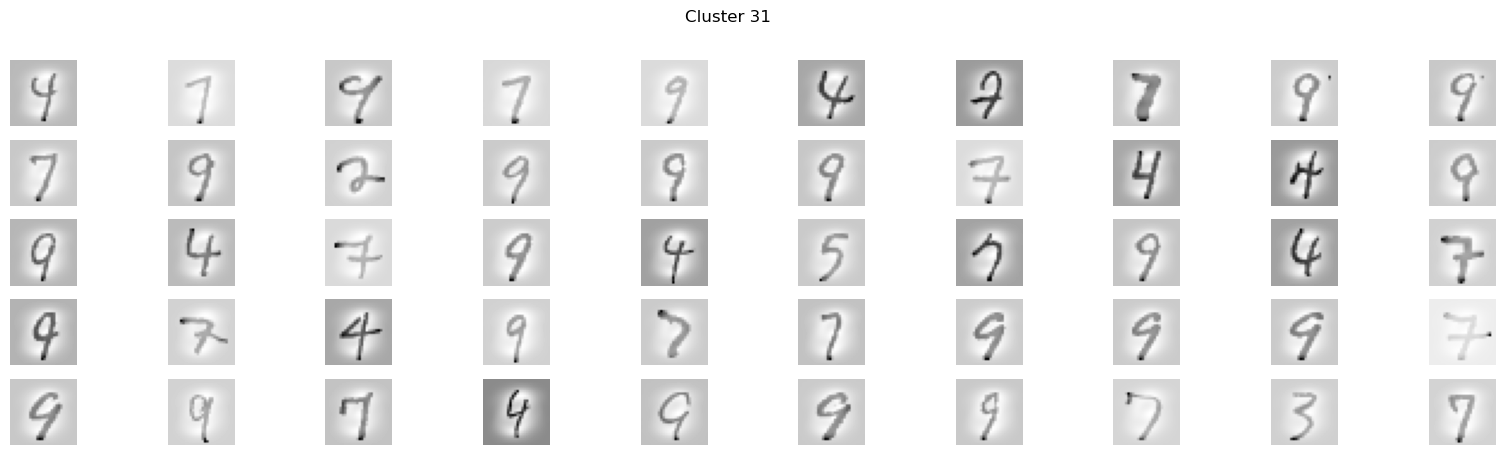

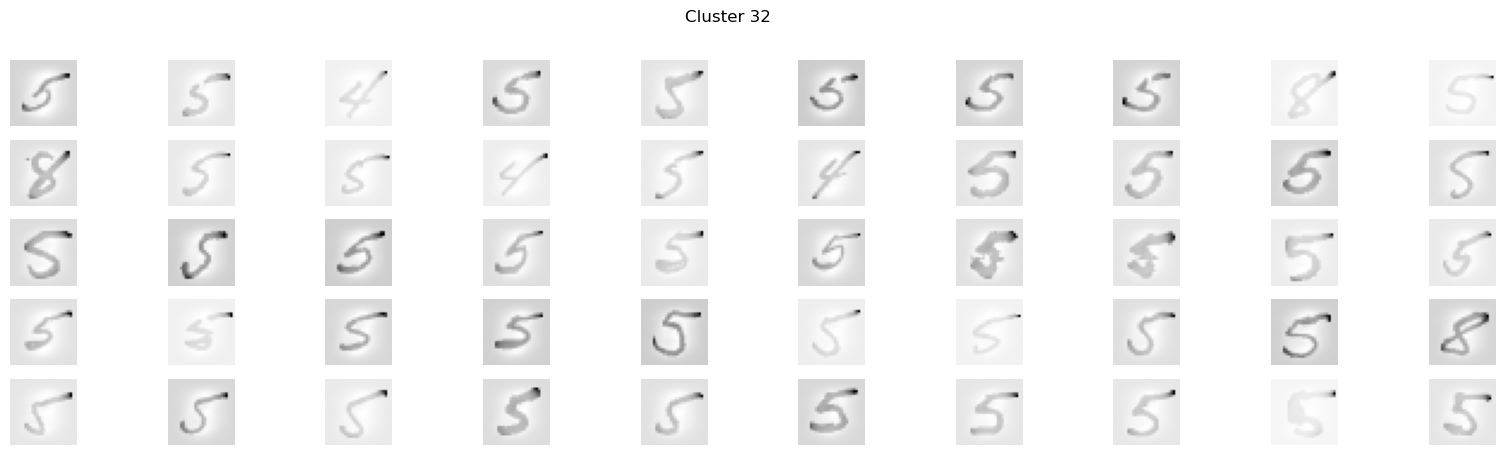

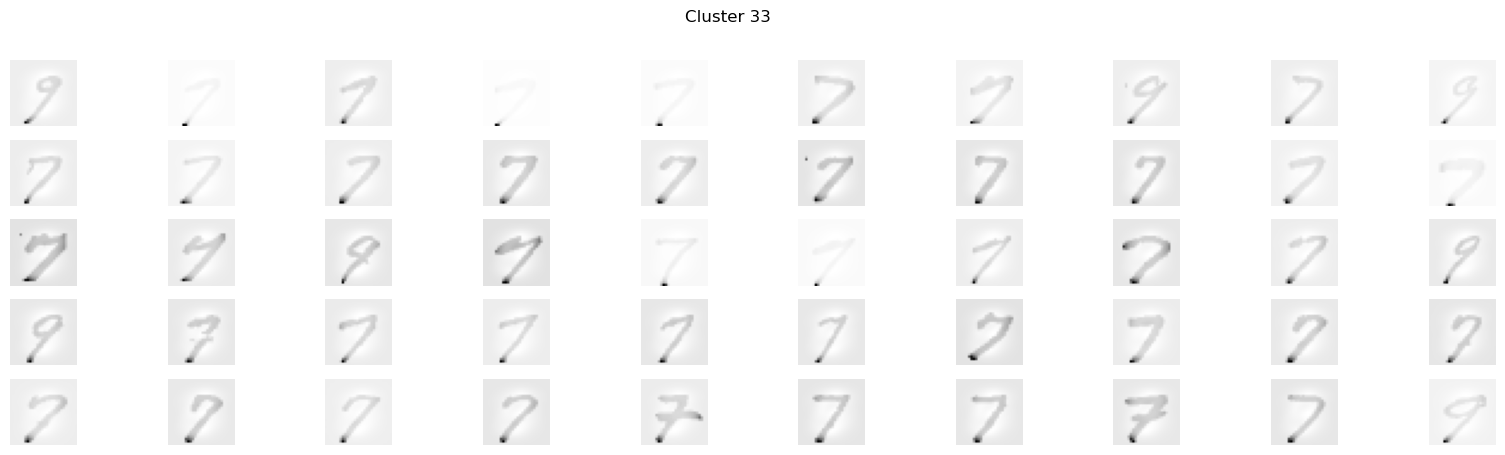

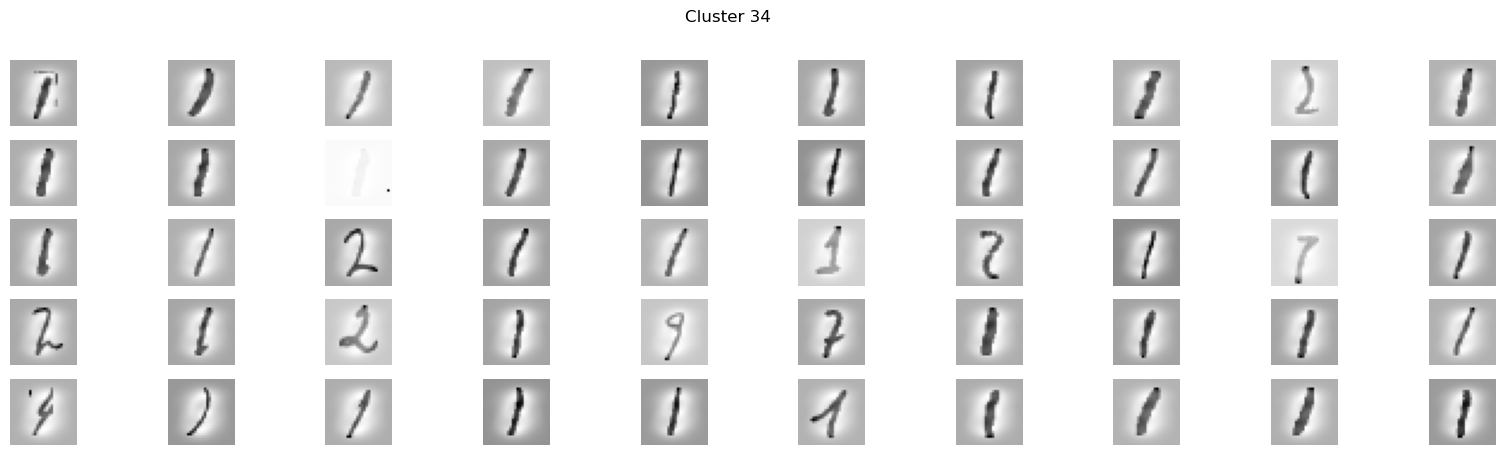

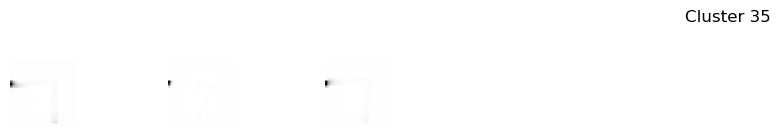

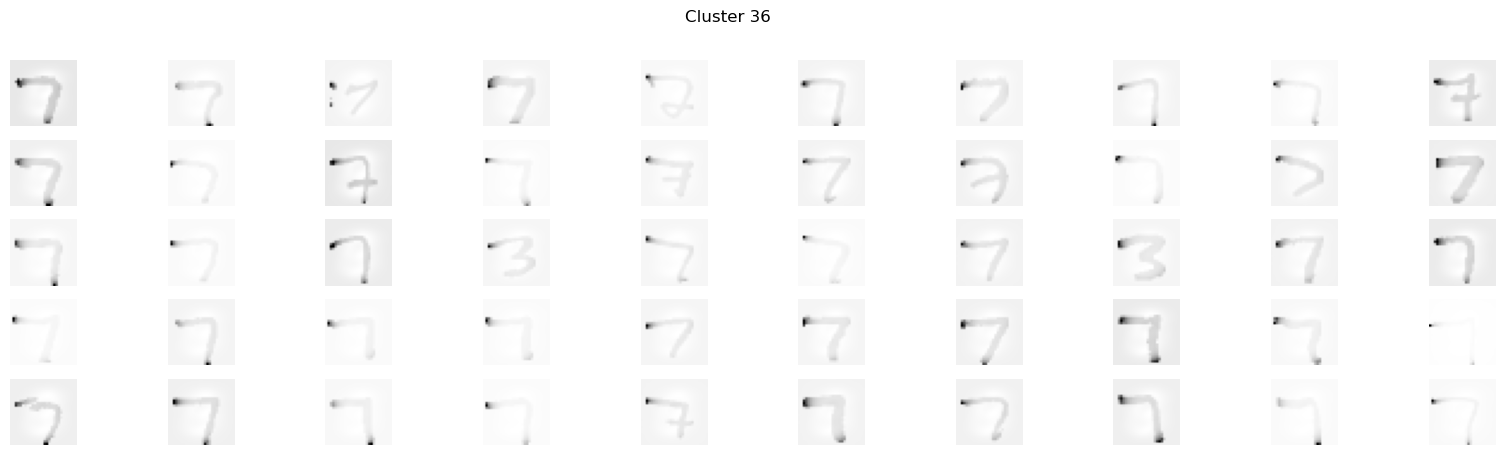

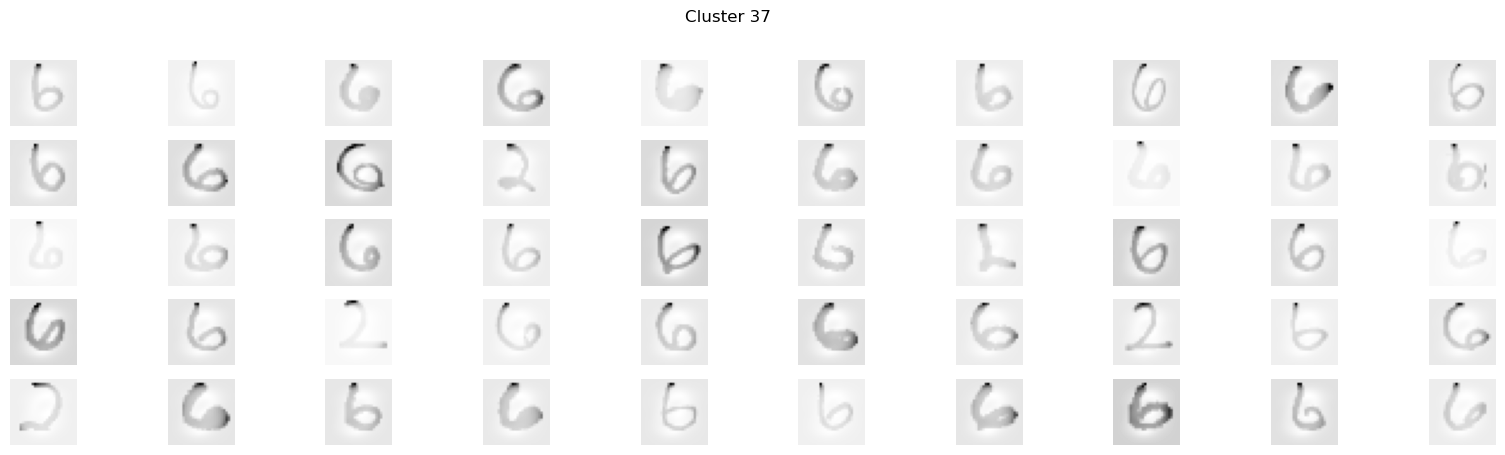

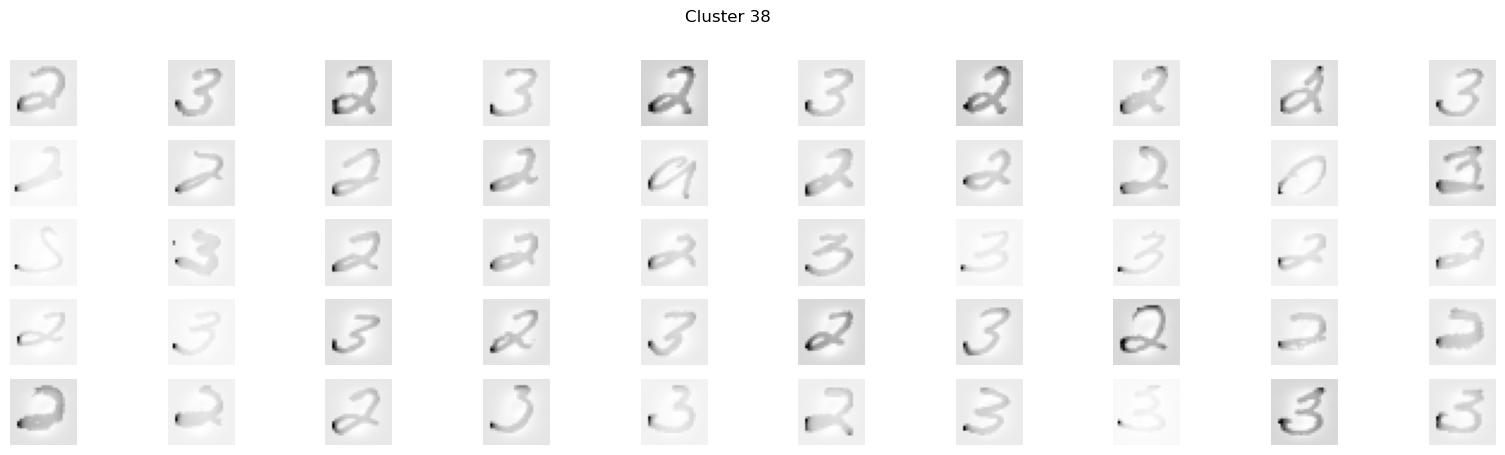

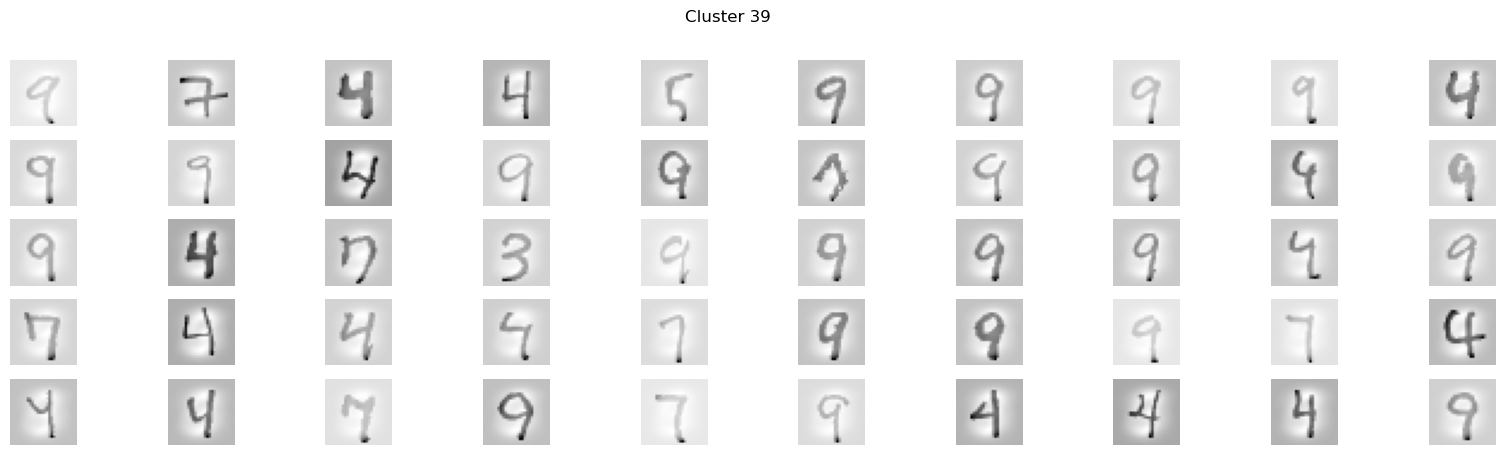

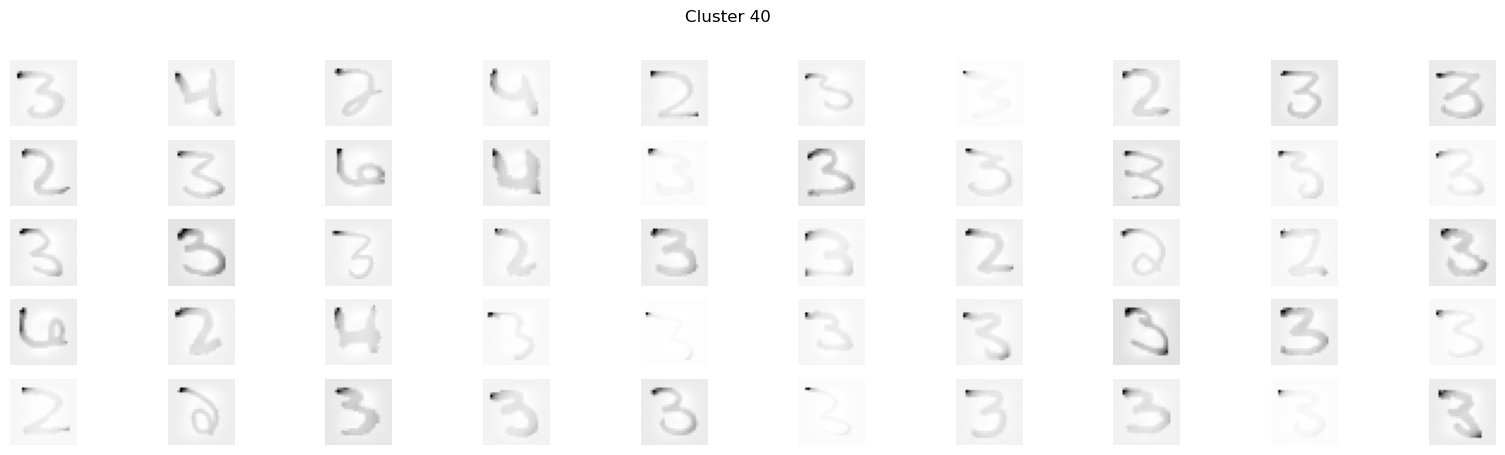

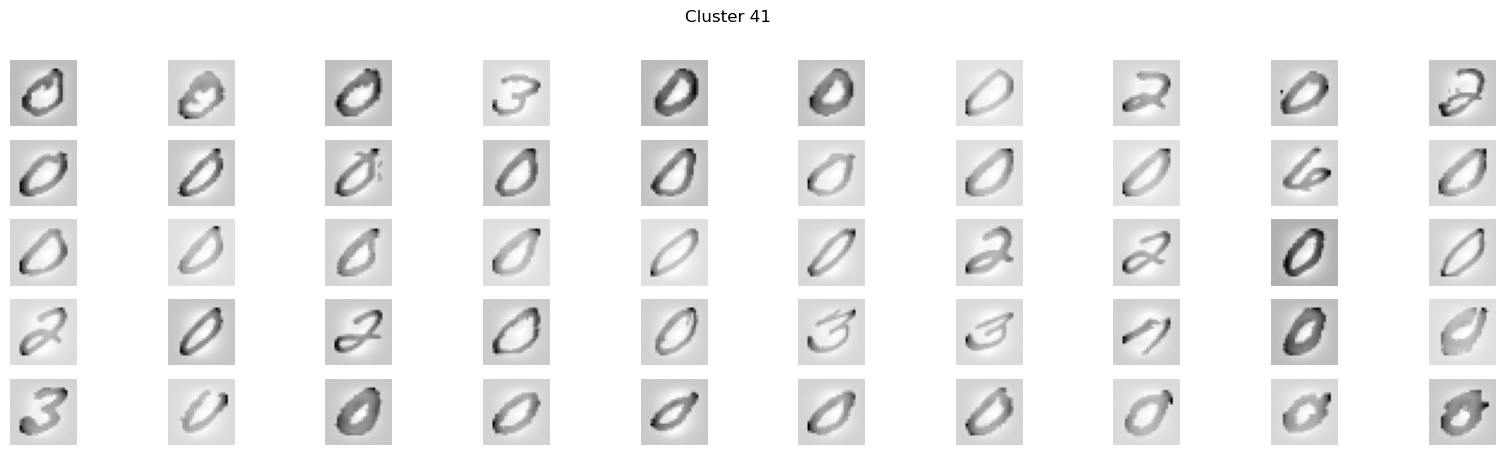

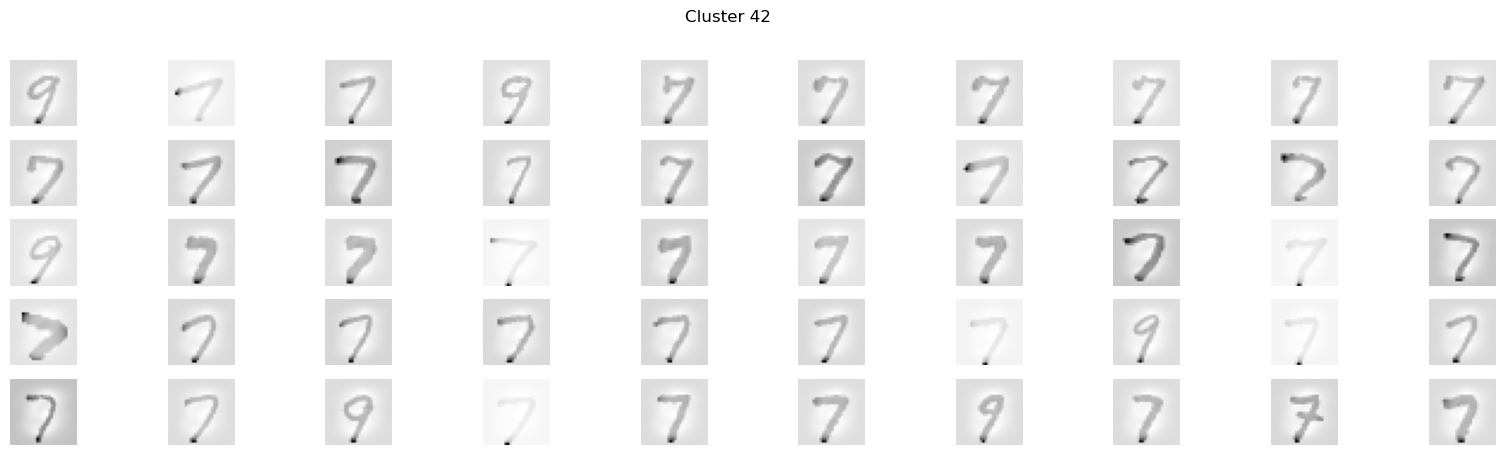

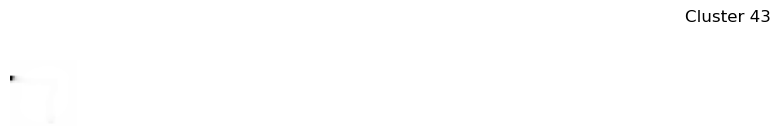

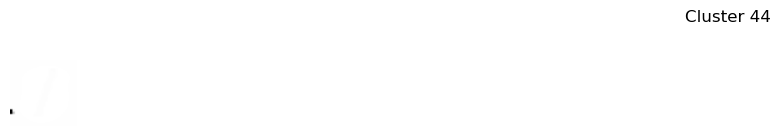

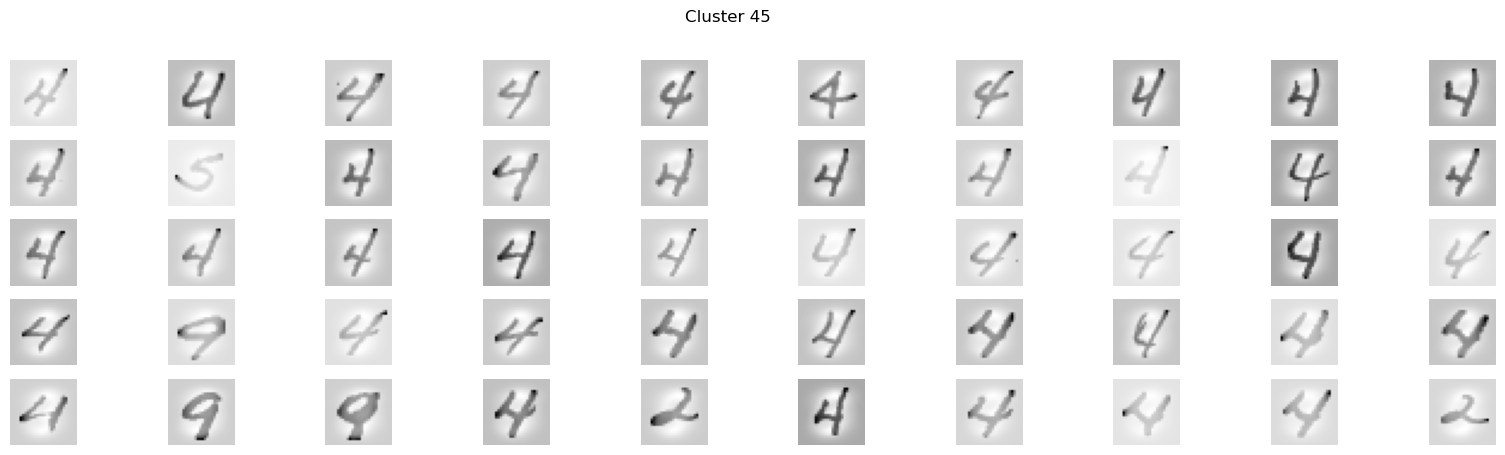

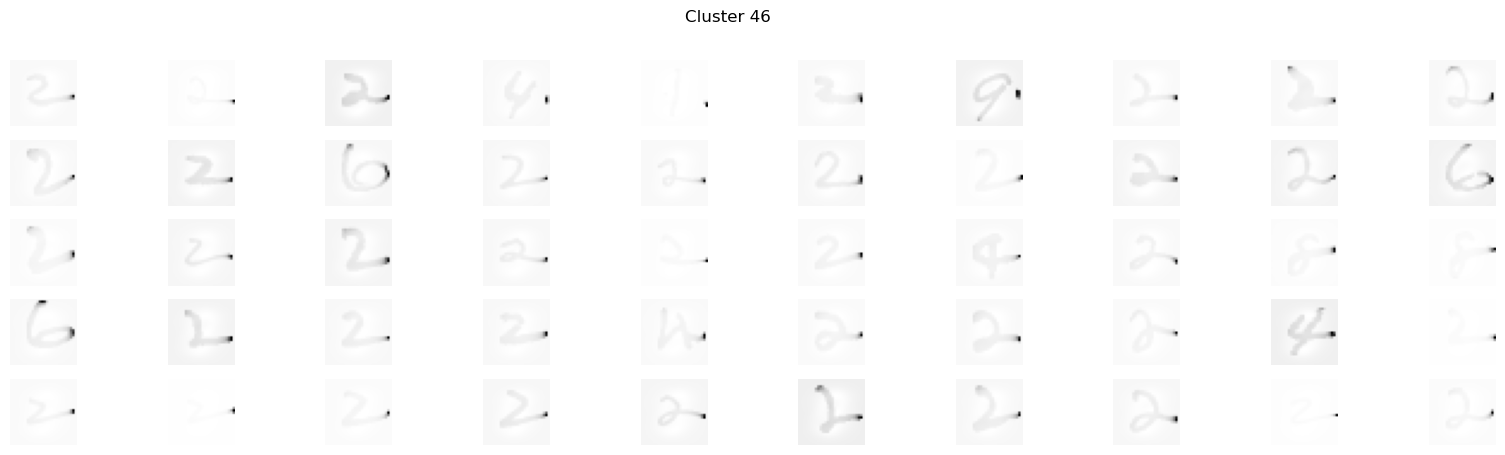

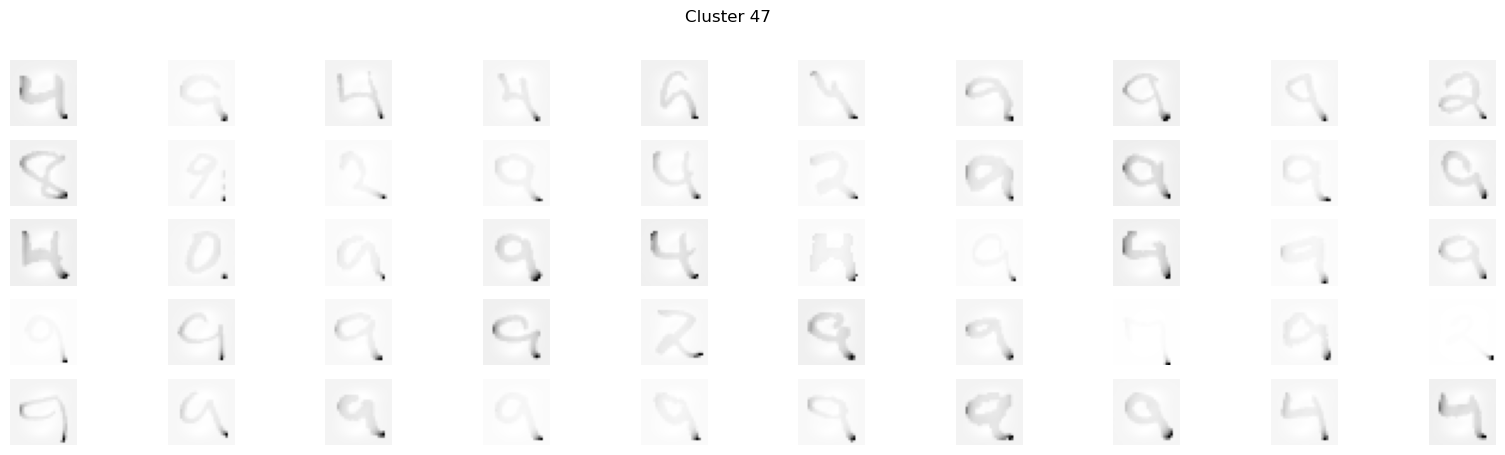

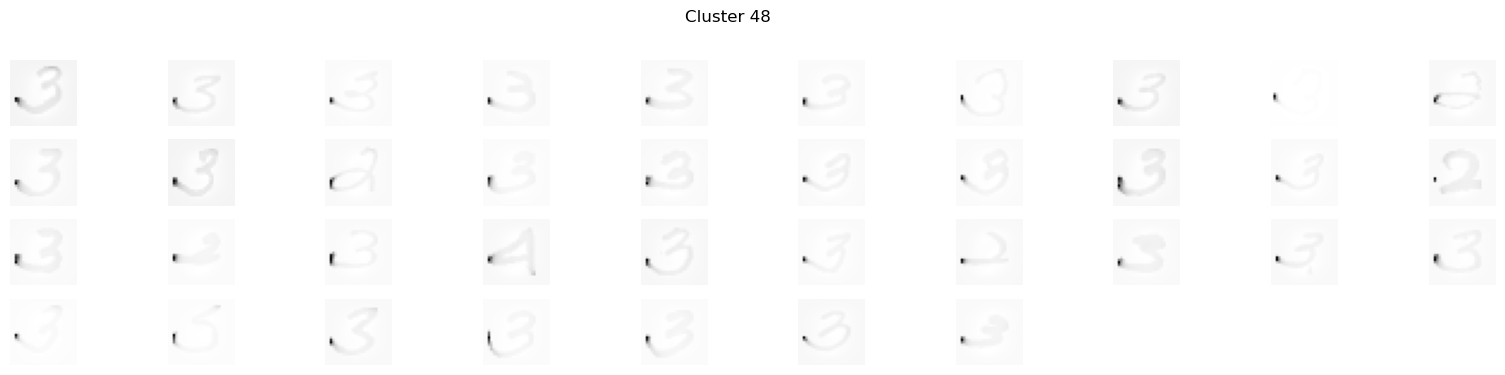

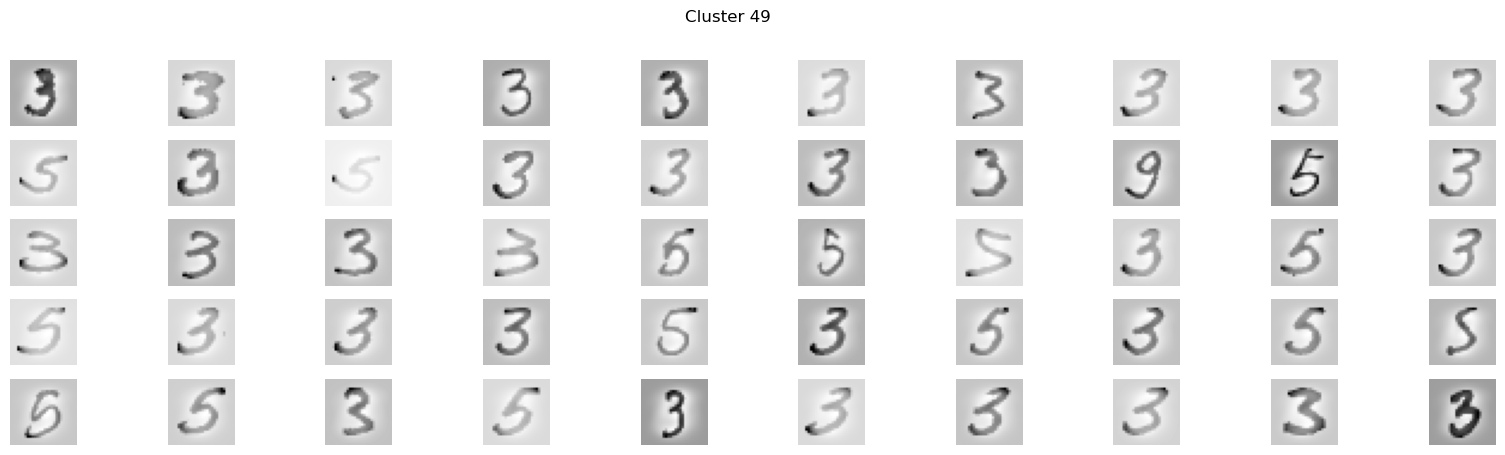

In [12]:
# Lets view the digits in each of our 50 clusters
# The following code iterates through each of the 50 clusters to prints out the first 50 images in each cluster using 'imshow()'.
for i in range(50):
    cluster_images = X_scaled[kmeans.labels_ == i]
    #cluster_images = test_df[test_df['Clusters'] == i]
    plt.figure(figsize=(20, 5))
    for j in range(50):
        if j < cluster_images.shape[0]:
            plt.subplot(5,10, j+1) # to show 50 digits within each cluster, j+1, so we dont get an error when a cluster doesnt has < 50 digits.
            plt.imshow(cluster_images[j].reshape(28, 28), cmap='binary') # using cmap=binary, i have very bad eyes..need reading glasses.....
            plt.axis('off')
    plt.suptitle(f'Cluster {i}') # title for each cluster image chart
    plt.show()

Create label_mapping to relabel the clusters after visually inspecting the 50 Clusters

For the above result, earlier during my first try, i was able to see the digits within the small clusters. But now with the 2nd run, i am not able to see them.
However, since 99% of the label_mapping were correct to the 2nd run, i decided to leave the small clusters labeling the same as well, even though i am not able to see the digits the second time around.

In [13]:
label_mappings_50 = {0: 8,   1: 2,    2: 1,    3:2 ,    4:2 ,    5: 7,    6: 0,    7: 4,
    8: 6, 9: 5,    10:9 ,    11:0 ,    12: 7,    13:5,    14: 6,    15: 3,    16: 3,
    17: 9,    18:6 ,    19: 7,    20: 1,    21:0,    22: 0,    23:0 ,    24: 6,    25: 9,    26:2 ,
    27: 3,    28: 6,    29: 8,    30: 8,    31: 9,    32: 5,    33: 7,    34: 1,    35: 7,    36: 7,
    37: 6,    38: 2,    39:9 ,    40: 3,    41: 0,    42: 7,    43: 7,    44:7 ,    45:4 ,    46: 2,
    47: 9,    48: 3,    49:3 }

Create our my own labels by mapping the the clusters and creating a new column called label.

In [14]:
# After visualizing the 50 clusters, create new column called labels to represent what each cluster represents 
# mapping the new label to label_mappings_50
test_df['label']=test_df['Clusters'].map(label_mappings_50)
test_df.head()

0    1    2    3    4    5    6    7    8    9  ...      776       777  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.01675 -0.010638   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.01675 -0.010638   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.01675 -0.010638   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.01675 -0.010638   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.01675 -0.010638   

        778       779  780  781  782  783  Clusters  label  
0 -0.008339 -0.005342  0.0  0.0  0.0  0.0        29      8  
1 -0.008339 -0.005342  0.0  0.0  0.0  0.0        22      0  
2 -0.008339 -0.005342  0.0  0.0  0.0  0.0        19      7  
3 -0.008339 -0.005342  0.0  0.0  0.0  0.0        20      1  
4 -0.008339 -0.005342  0.0  0.0  0.0  0.0        39      9  

[5 rows x 786 columns]

Delete the Clusters column as we no longer need it.

In [15]:
# Now that we have created a new column called Label that is mapped through visual inpection of the 50 clusters, we can now drop the column Clusters.
test_df.drop('Clusters', inplace=True, axis=1)
test_df

0    1    2    3    4    5    6    7    8    9  ...       775  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
69995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
69996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
69997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
69998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   
69999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023387   

           776       777       778       779  780  781  782  783  label  
0     -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      8  
1     -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      0  
2     -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      7  
3     -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      1  
4     -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      9  
...        ...       ...       ...       ...  ...  ...  ...  ...    ...  
69995 -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      2  
69996 -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      3  
69997 -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      9  
69998 -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      5  
69999 -0.01675 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      6  

[70000 rows x 785 columns]

Creating the test_df dataframe and manually labeling the clusters can help to improve the interpretability and usability of the clusterting results, and make it easier to explore and analyze the data further.

Test to see if the clusters were labelled correctly.

In [16]:
# Function to view the cluster and the label assgined to it after visually mapping the clusters
def show_cluster(cluster_number):
    label = label_mappings_50[cluster_number]
    cluster_images = X_scaled[test_df['label'] == label]
    #cluster_images = test_df[test_df['label'] == label] # this is throwing an error
    plt.figure(figsize=(20, 5))
    for j in range(50):
        if j < cluster_images.shape[0]:
            plt.subplot(5,10, j+1)
            plt.imshow(cluster_images[j].reshape(28, 28), cmap='binary')
            plt.axis('off')
    plt.suptitle(f'Cluster: {cluster_number}, Mapped as: {label}')
    plt.show()

In [16]:
#def show_cluster2(cluster_number):
    #label = label_mappings_50[cluster_number]
    #cluster_images = test_df[test_df['label'] == cluster_number].iloc[:, :-1]
    #plt.figure(figsize=(20, 5))
    #for j in range(50):
        #if j < cluster_images.shape[0]:
            #plt.subplot(5,10, j+1)
            #plt.imshow(cluster_images.iloc[j].values.reshape(28, 28), cmap='binary')
            #plt.axis('off')
    #plt.suptitle(f'Cluster: {cluster_number}, Mapped as: {label}')
    #plt.show()

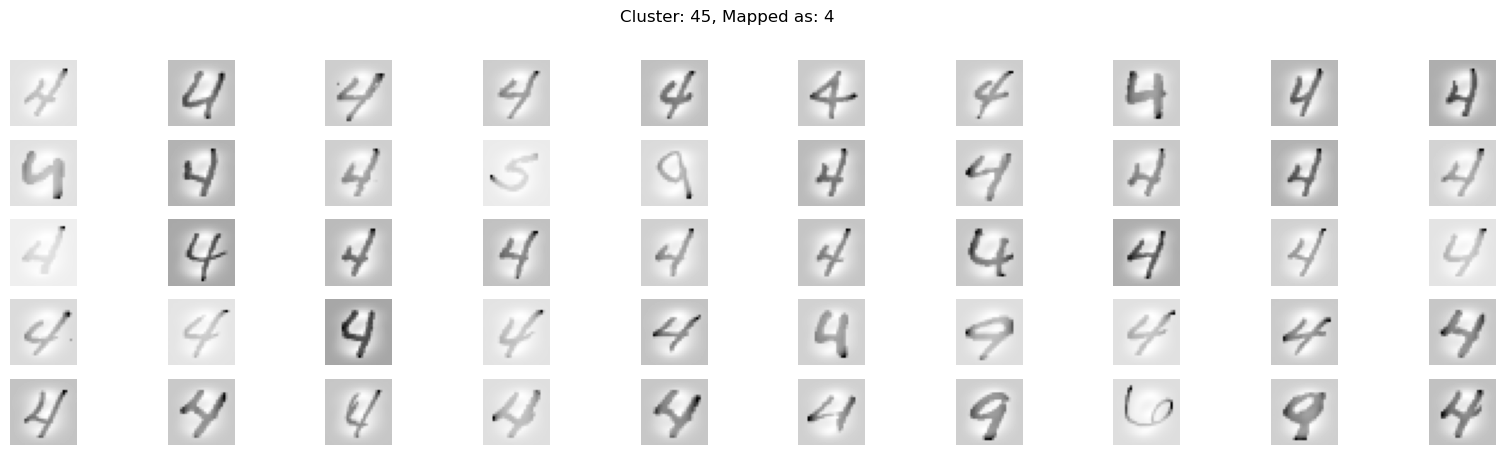

In [17]:
show_cluster(45)

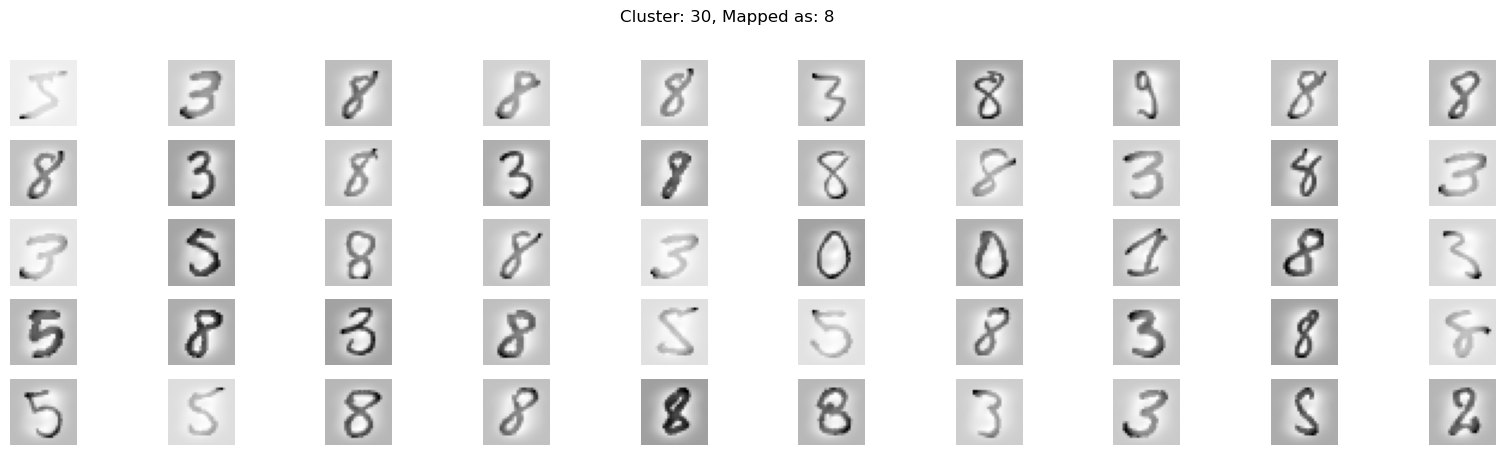

In [18]:
show_cluster(30)

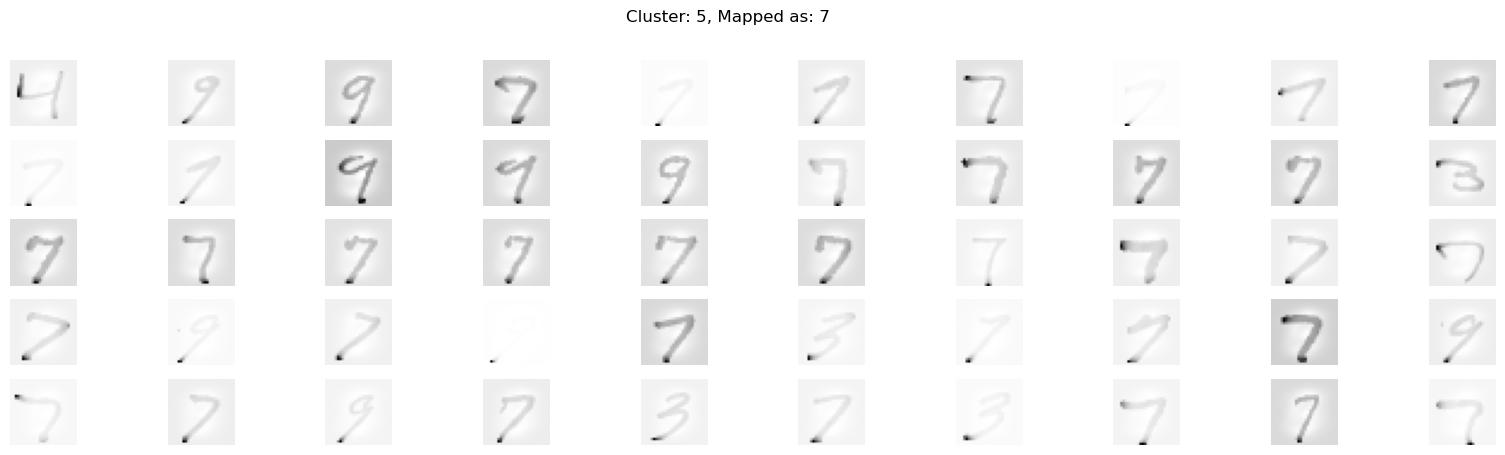

In [19]:
show_cluster(5)

This may not be correct, but, some of the labels were created by looking at the most popular count of each digit displayed in a cluster, and then using intuition as to why they were clustered together.

Generate a handwritten number for each digit in an input integer and display them.

The writeNumber() function below, contains the GaussianMixture imbeded into the function. This way there is no need to create a secondary fnction just for GMM.

In [20]:
def writeNumber(num):
    # Convert the integer to a string
    num_str = str(num)
    
    # Generate a new handwritten number for each digit
    for digit in num_str:
        # Get all images in the cluster corresponding to the digit
        cluster_num = test_df[test_df['label'] == int(digit)] # choose the cluster that corresponds to where digit== assigned label.
        cluster_images = cluster_num.drop(['label'], axis=1).to_numpy()
        
        # Build a GMM for the cluster
        #gmm = GaussianMixture(covariance_type='full', random_state=42)
        gmm = GaussianMixture(covariance_type='full')
        gmm.fit(cluster_images)
        
        # Generate a new handwritten number using the GMM
        new_image = gmm.sample()[0]
        
        # Reshape the image to 28x28 and display it
        plt.figure(figsize=(1, 1))
        plt.imshow(new_image.reshape((28, 28)), cmap='gray')
        plt.axis('off')
        plt.show()

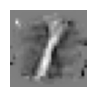

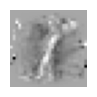

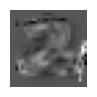

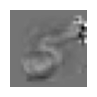

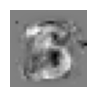

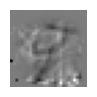

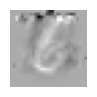

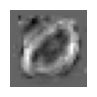

In [21]:
writeNumber(11258960)

Ahhhhhhhh, need the output to be horizontal.

In [23]:
# Code modified to show output horizontally instead of vertically.
def writeNumber2(num):
    
    # Convert the integer to a string
    num_str = str(num)
    
    # Create a figure with subplots for each digit horizontally
    fig, axs = plt.subplots(1, len(num_str), figsize=(len(num_str), 1))
    
    # Generate a new handwritten number for each digit
    for i, digit in enumerate(num_str):
        # Get all images in the cluster corresponding to the digit
        cluster_num = test_df[test_df['label'] == int(digit)]
        cluster_images = cluster_num.drop(['label'], axis=1).to_numpy()
        
        # Build a GMM for the cluster
        #gmm = GaussianMixture(covariance_type='full', random_state=42)
        gmm = GaussianMixture(covariance_type='full') 
        # removed random_state=42 so we can generate a new digit for every iteration of the input num
        """Unfortunately, we need to make sure that when generating the handwritten numbers, ...
            each version of a digit should be different. 
            Each digit generated should be a new generation of data."""
        gmm.fit(cluster_images)
        
        # Generate a new handwritten number using the GMM
        new_image = gmm.sample()[0]
        
        # Reshape the image to 28x28 and display it
        axs[i].imshow(new_image.reshape((28, 28)), cmap='binary')
        axs[i].axis('off')
    
    plt.show()

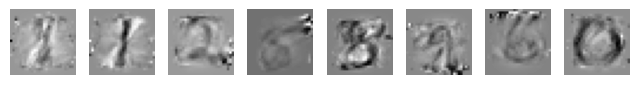

In [24]:
writeNumber2(11258960)

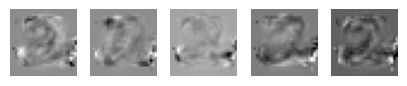

In [25]:
# check to see if the digits are randomly generated
writeNumber2(22222)

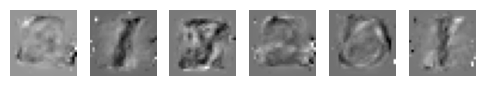

In [26]:
## Answer to the assignemnt 3
writeNumber2(218201)

Another way to make sure GMM generates a new image:

In the writeNumber() function below, we are using pandas time, where we can use the current time in seconds as the seed value for the GMM model, along with an additional offset for each digit to ensure a unique seed value for each. This way, each generated digit will be unique, evem if it is the same digit as previous ones in the input number.

In hindsight, i guess, it would've been better to have a seperate GMM function to generate a new digit from the information clusters.
And the writefunction() would then call the GMM generator for every digit, giving a new digit for every instance.

In [26]:
import time
"""time.time() is a method that returns the current time in seconds since the epoch as a floating-point number. 
In the context of the function we modified, it was used to ensure that each digit's GMM model was initialized with a unique seed value. 
Since the GMM model uses random initialization, setting a different seed value for each digit ensures that the generated images for each digit...
are distinct and not just repetitions of the same image. 
By using time.time() as the seed value and adding the loop index i, we create a different seed value for each iteration of the loop, 
thus ensuring that each digit's model is initialized with a different seed value."""

def writeNumber3(num):
    # Convert the integer to a string
    num_str = str(num)
    
    # Create a figure with subplots for each digit
    fig, axs = plt.subplots(1, len(num_str), figsize=(len(num_str), 1))
    
    # Generate a new handwritten number for each digit
    for i, digit in enumerate(num_str):
        # Get all images in the cluster corresponding to the digit
        """ Here we are slecting a subset of the dataset that contains all the images that correspond to the digits (num).
        """
        cluster_num = test_df[test_df['label'] == int(digit)]# creates a boolean mask that is True for each row in the test_df where the label matches the current digit.
        cluster_images = cluster_num.drop(['label'], axis=1).to_numpy() #drops the label column from the cluster_num dataframe, leaving only the pixel values for each image.
        """Then converts the remaining dataframe into a numpy array of shape (n_samples, n_features) where n_smaples is the number of images that correspond to the current digit...
            and n_features is the number of pixels in each image.
            cluster_images is a numpy array that contains all the pixel values for each image in the dataframe test_df that corresponds to the current digit from num.
            This digit is that used in the following code to fit a Gaussian mixture model for the current digit and generate a new handwritten number""" 
        
        # Build a GMM for the cluster
        seed_val = int(time.time()) + i  # use different seed for each digit: as per explaination above.
        gmm = GaussianMixture(covariance_type='full', random_state=seed_val)
        # as per class on March 21, i realized, we can just let random_state=0 or None.
        gmm.fit(cluster_images)
        
        # Generate a new handwritten number using the GMM
        """ Here the code is generating a new handwritten number using the GMM model and then extracting the first element of the resulting Numpy array.
            Since the above code generates a single sample, the resulting array has only one element, which is 1D array of length, n_features.
                By taking the first element pf this array, the code is effectively flattening the array into a 1D vector of length n_features."""
        new_image = gmm.sample()[0]
        
        # Reshape the image to 28x28 and display it
        axs[i].imshow(new_image.reshape((28, 28)), cmap='binary') # reshape the 1D vector into a 2D shape of (28,28)
        axs[i].axis('off')
    
    plt.show()

    """ After the Tuesday, March 21st, 2023 ML Class, i realized that all i really needed to do was to set random_state=0 or NONE...
        for the Gaussian Mixture to generate a different cluster_images. 
        However, i am glad i got the chance to look into the time.time() function for future ML application."""

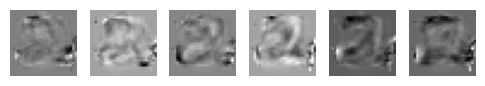

In [27]:
writeNumber3(222222)

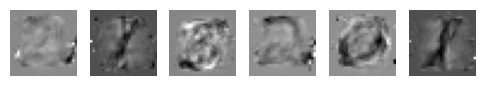

In [28]:
## Answer to the assignemnt 3
writeNumber3(218201)

The above code now generates different instances of each digit generated, instead of the same digit being recycled.

March 21, 2023: i thought i had finished the assignemnt and was about to submit this. But then decided to take the writeNumber3() function above and split it into two differemt functions: for practice. 

In [29]:
# Define a function to generate a new handwritten digit using a GMM
import matplotlib as mpl
def generateDigit_GMM(num):
    # Convert the integer to a string
    num_str = str(num)

    # Initialize the GMM model
    gmm = GaussianMixture(covariance_type='full', random_state=None )
    # random_state set to random_seed=None, so that we can generate different samples for every iteration.
    # I have used covariance_type='full' as per ML class lectrure examples.
    # All other parameters are set to default to get the best accuracy. We are not worried about overfitting here.

    # Generate a new handwritten number for each digit
    for digit in num_str:
        # Get all images in the cluster corresponding to the digit
        cluster_num = test_df[test_df['label'] == int(digit)]
        cluster_images = cluster_num.drop(['label'], axis=1).to_numpy()

        # Fit the GMM model to the cluster
        gmm.fit(cluster_images)

        # Generate a new handwritten number using the GMM
        new_image = gmm.sample()[0]

        yield new_image.reshape((28, 28)) #using yield function instead of return
        """ The Yield keyword in Python is similar to a return statement used for returning values or objects in Python. 
            However, there is a slight difference. The yield statement returns a generator object to the one ..
            who calls the function which contains yield, instead of simply returning a value. 
            Hence no need to create a list here, in this function."""

# Define a function to plot a handwritten number
def writeNumber4(num):
    # Generate a list of handwritten digits using the generateDigit function
    digits = list(generateDigit_GMM(num))

    # Create a figure with subplots for each digit
    fig, axs = plt.subplots(1, len(digits), figsize=(len(digits), 1))

    # Plot each handwritten digit
    for i, digit in enumerate(digits):
        axs[i].imshow(digit, cmap=mpl.cm.binary) 
        # changed cmap=mpl.cm.binary as per 016_cluster_2 class notebook.
        axs[i].axis('off')

    plt.show()

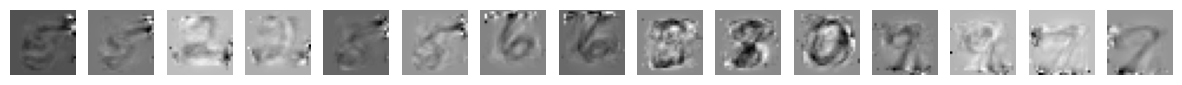

In [30]:
writeNumber4(552255668809977)

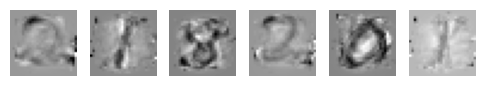

In [31]:
# Answer to the assignemnt 3
writeNumber4(218201)

SOLID GOLD!!!

This was a very difficult assignemnt.